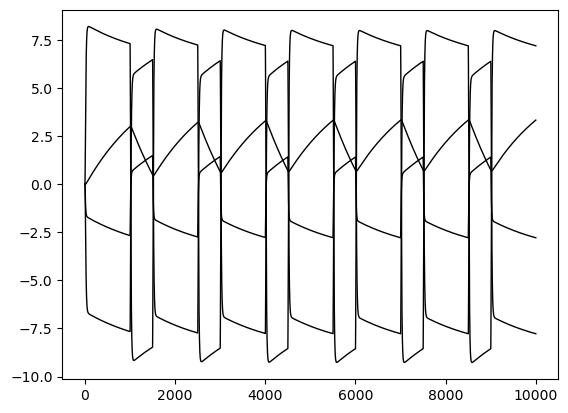

In [8]:
from toolbox import OneDModel_TBK as ODM
import matplotlib.pyplot as plt
import numpy as np
import importlib
importlib.reload(ODM)

Temps, F, Fadv = ODM.OneDModel(show_figures=False)

time = np.arange(1, len(np.squeeze(Temps[0, 0, 1, :])) + 1)

plt.figure()
idx=9
# Last loop (i == 10), plot in black
plt.plot(time, Temps[idx, 0, 1, :], 'k', linewidth=1)
plt.plot(time, Temps[idx, 0, 2, :], 'k', linewidth=1)
plt.plot(time, Temps[idx, 0, 3, :], 'k', linewidth=1)
plt.plot(time, Temps[idx, 0, 4, :], 'k', linewidth=1)

Text(0, 0.5, 'Temperature')

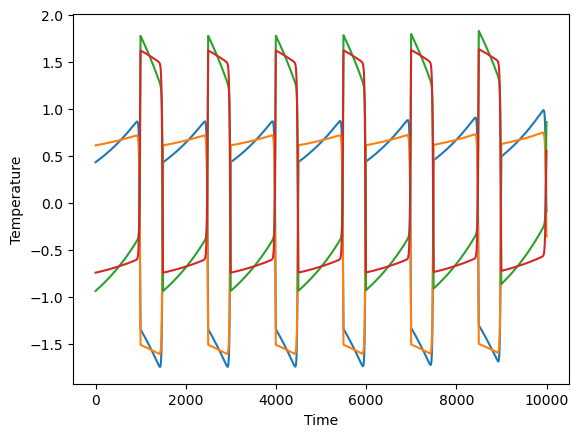

In [ ]:
idx = 9  # Index of the last simulation without noise
# Convert the dictionary to an array suitable for Tigramite's DataFrame
data_array = Temps[idx, 0, 1:5, :].T.copy()

# For data_array, for the first column, replace it with its derivative
first_col_diff = np.diff(data_array[:, 0])
# drop the last row of data_array
data_array = data_array[:-1, :]
# replace the first column with the derivative
data_array[:, 0] = first_col_diff



# normalize the data_array using z-score
from scipy.stats import zscore
data_array = zscore(data_array, axis=0)



# flipe the the array upside down
data_array = np.flipud(data_array)
time = np.arange(1, len(np.squeeze(Temps[0, 0, 1, :])) )

# plot the data_array time series
import matplotlib.pyplot as plt
plt.plot(time, data_array)
plt.xlabel('Time')
plt.ylabel('Temperature')

In [13]:
data_array.shape

(9999, 4)

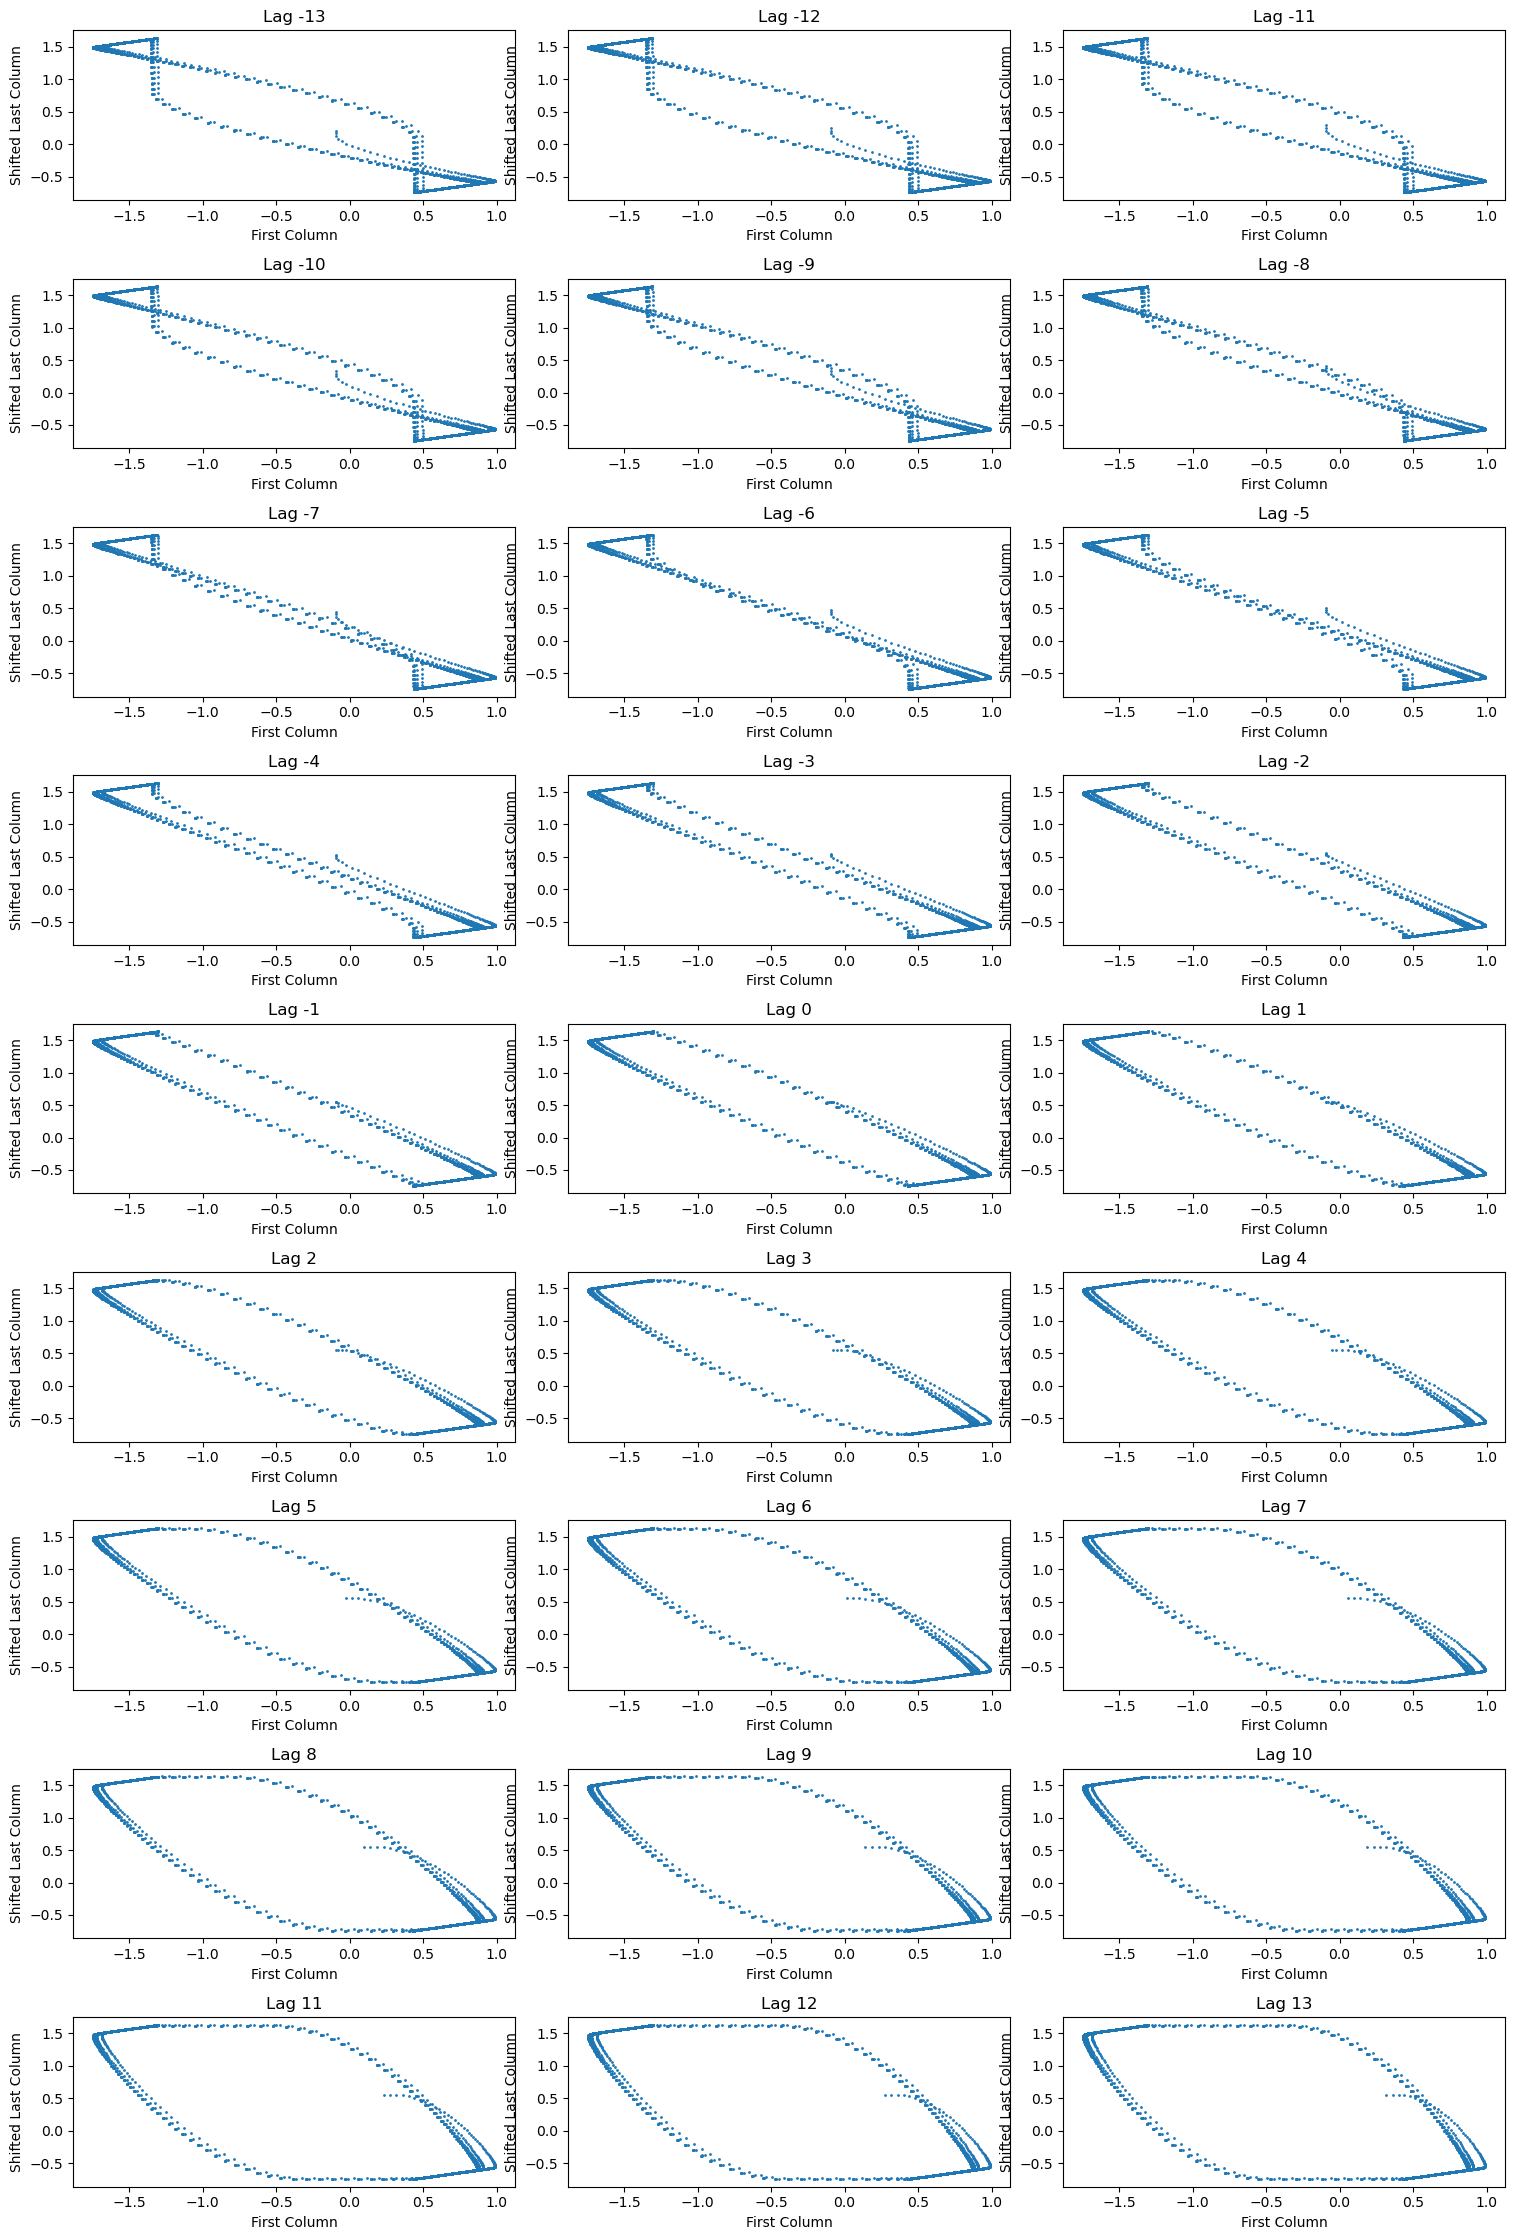

In [21]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming data_array is given and has the shape (9999, 4)
# For demonstration, let's create a sample data_array
# Uncomment the following line if you need to generate sample data
# data_array = np.random.randn(9999, 4)

# 1. Extract the first and last columns
col1 = data_array[:, 0]
col_last = data_array[:, -1]

# 2. Define the range of lags (-3 to 20)
lags = range(-13, 14)

# Determine the layout for subplots
nrows = 9
ncols = 3
fig, axes = plt.subplots(nrows, ncols, figsize=(15, nrows * 2.5))
axes = axes.flatten()  # Flatten the axes array for easy indexing

for idx, lag in enumerate(lags):
    # Shift the last column by the current lag
    if lag > 0:
        shifted_col_last = col_last[lag:]
        col1_shifted = col1[:-lag]
    elif lag < 0:
        lag_abs = -lag
        shifted_col_last = col_last[:-lag_abs]
        col1_shifted = col1[lag_abs:]
    else:  # lag == 0
        shifted_col_last = col_last
        col1_shifted = col1

    # Ensure the lengths match
    min_length = min(len(col1_shifted), len(shifted_col_last))
    col1_shifted = col1_shifted[:min_length]
    shifted_col_last = shifted_col_last[:min_length]

    # Plot the scatter plot in the corresponding subplot
    axes[idx].scatter(col1_shifted, shifted_col_last, s=1)
    axes[idx].set_title(f'Lag {lag}')
    axes[idx].set_xlabel('First Column')
    axes[idx].set_ylabel('Shifted Last Column')

# Remove any unused subplots
for idx in range(len(lags), nrows * ncols):
    fig.delaxes(axes[idx])

plt.tight_layout()
plt.show()


# PCMCI using differenciated data

(<Figure size 640x480 with 4 Axes>,
 array([<Axes: ylabel='Box 1'>, <Axes: ylabel='Box 2'>,
        <Axes: ylabel='Box 3'>, <Axes: ylabel='Box 4'>], dtype=object))

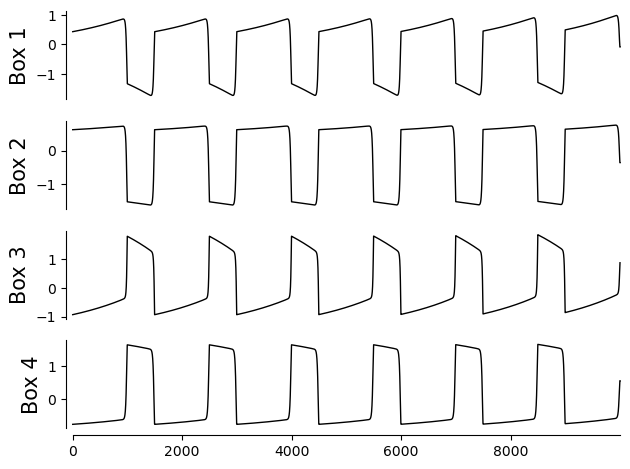

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import tigramite
from tigramite import data_processing as pp
from tigramite import plotting as tp
from tigramite.pcmci import PCMCI
from tigramite.independence_tests import parcorr, gpdc, cmiknn
import pandas as pd

# Create a Tigramite DataFrame object
var_names = [f"Box {k+1}" for k in range(4)]

# create adataframe called 'df4stationary_check' with the data_array and the variable names
df4stationary_check= pd.DataFrame(data_array, columns=var_names)

dataframe_TEMP = pp.DataFrame(data_array, datatime=np.arange(data_array.shape[0]), var_names=var_names)
tp.plot_timeseries(dataframe_TEMP,label_fontsize=15,tick_label_size=10)


##
## Step 1: PC1 algorithm for selecting lagged conditions
##

Parameters:
independence test = par_corr
tau_min = 1
tau_max = 2
pc_alpha = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
max_conds_dim = None
max_combinations = 1



## Resulting lagged parent (super)sets:

    Variable Box 1 has 0 link(s):
    [pc_alpha = 0.05]

    Variable Box 2 has 3 link(s):
    [pc_alpha = 0.5]
        (Box 2 -2): max_pval = 0.00000, |min_val| =  0.155
        (Box 2 -1): max_pval = 0.37726, |min_val| =  0.009
        (Box 4 -2): max_pval = 0.43012, |min_val| =  0.008

    Variable Box 3 has 4 link(s):
    [pc_alpha = 0.3]
        (Box 3 -2): max_pval = 0.05226, |min_val| =  0.019
        (Box 1 -2): max_pval = 0.19727, |min_val| =  0.013
        (Box 1 -1): max_pval = 0.20156, |min_val| =  0.013
        (Box 2 -2): max_pval = 0.22106, |min_val| =  0.012

    Variable Box 4 has 1 link(s):
    [pc_alpha = 0.3]
        (Box 4 -1): max_pval = 0.28533, |min_val| =  0.011

##
## Step 2: MCI algorithm
##

Parameters:


(<Figure size 2000x2000 with 1 Axes>, <Axes: >)

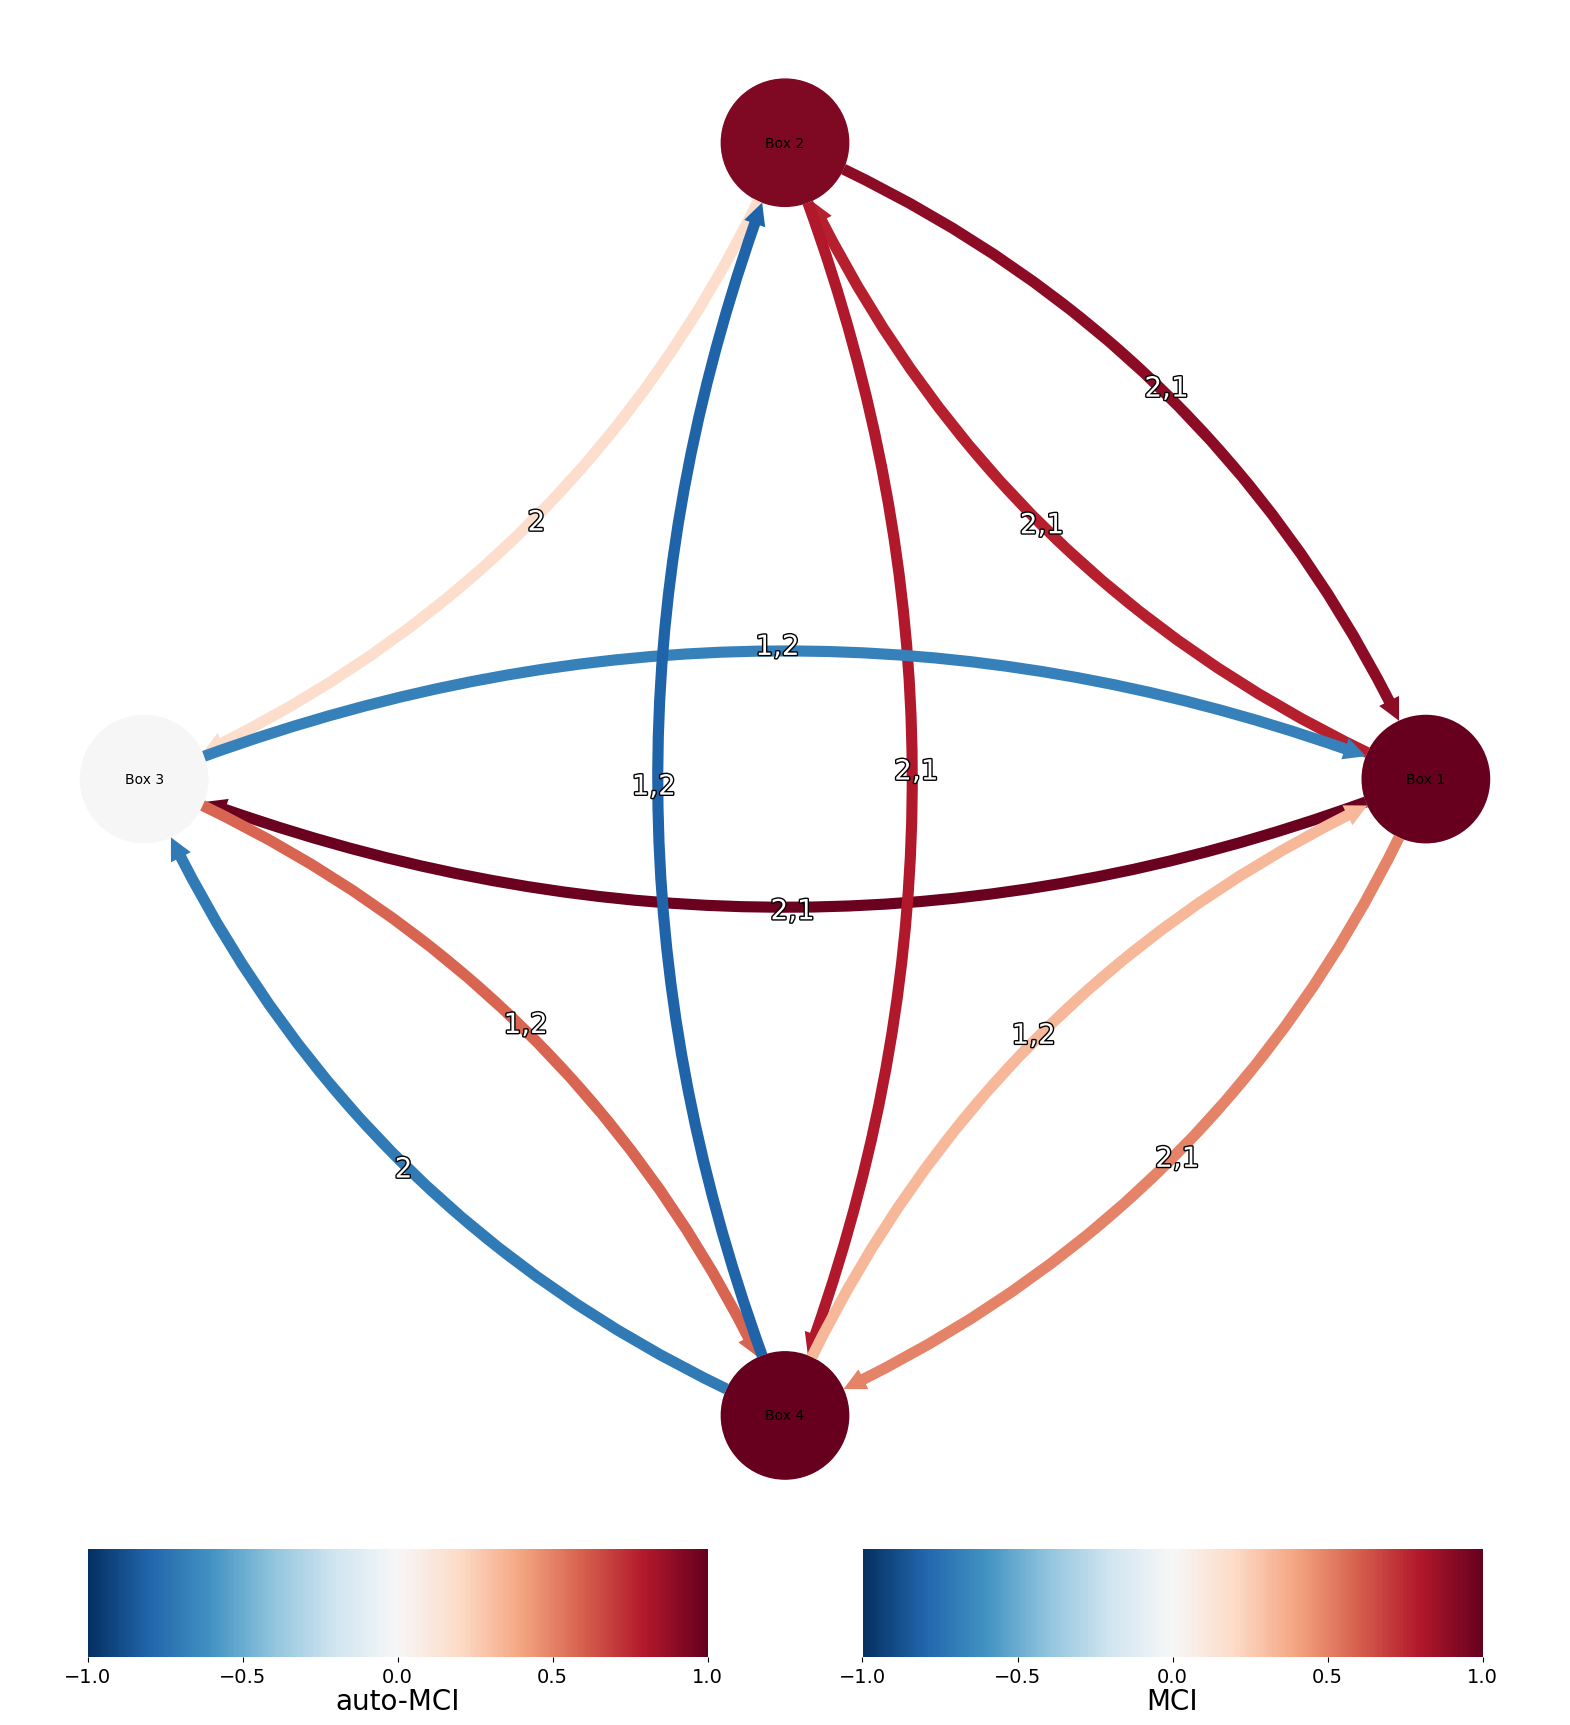

In [12]:
ParCorr = parcorr.ParCorr(significance='analytic')
pcmci = PCMCI(
    dataframe=dataframe_TEMP,
    cond_ind_test=ParCorr,
    verbosity=1)

pcmci.verbosity = 1
tau_min=1
tau_max=2
results = pcmci.run_pcmci(tau_min=tau_min, tau_max=tau_max, pc_alpha=None)
# q_matrix = pcmci.get_corrected_pvalues(p_matrix=results['p_matrix'], tau_max=tau_max, fdr_method='fdr_bh')

# create a figure
fig, ax = plt.subplots(1, 1, figsize=(20, 20), dpi=100)
tp.plot_graph(
    fig_ax=(fig, ax),
    graph = results['graph'],
    val_matrix=results['val_matrix'],
    var_names=var_names,
    link_colorbar_label='MCI',
    node_colorbar_label='auto-MCI',
    link_label_fontsize=20,
    label_fontsize=20,
    tick_label_size=14,
    node_label_size=10,
    edge_ticks=0.5,
    node_ticks=0.5,
    node_size=0.2
    )

Column 0: Max correlation at lag -300 with value 0.0999701298278011


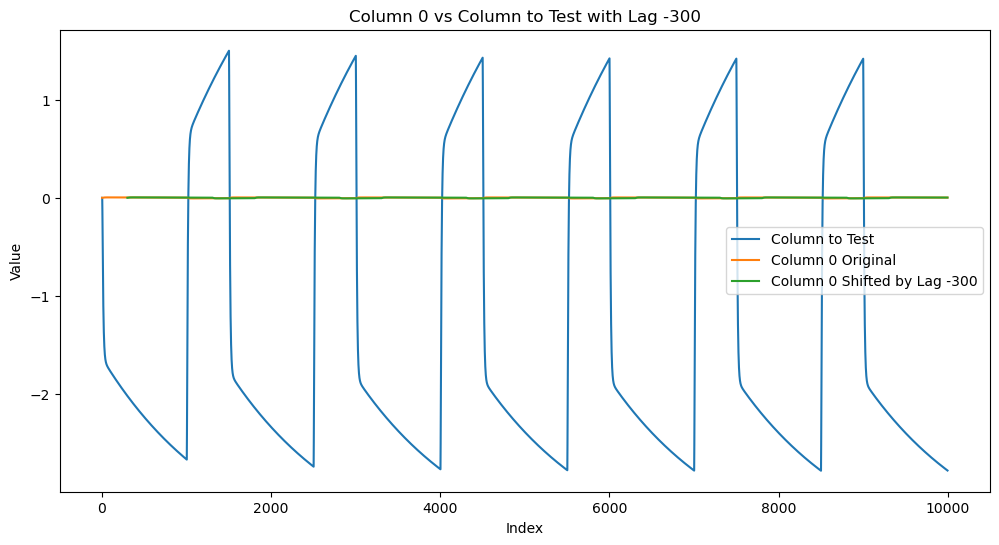

Column 1: Max correlation at lag -300 with value 0.01243979811454335


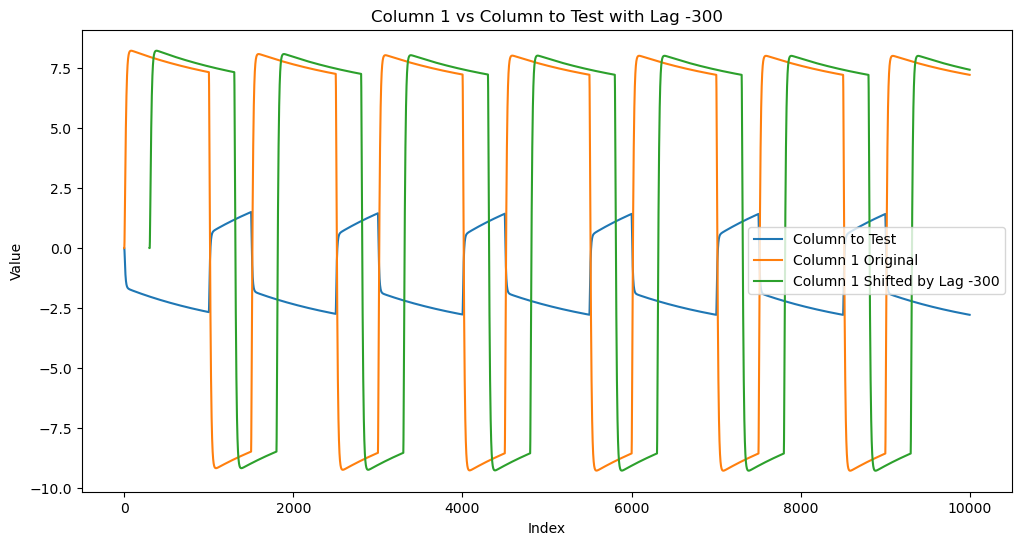

Column 3: Max correlation at lag -3 with value 0.9925066696590001


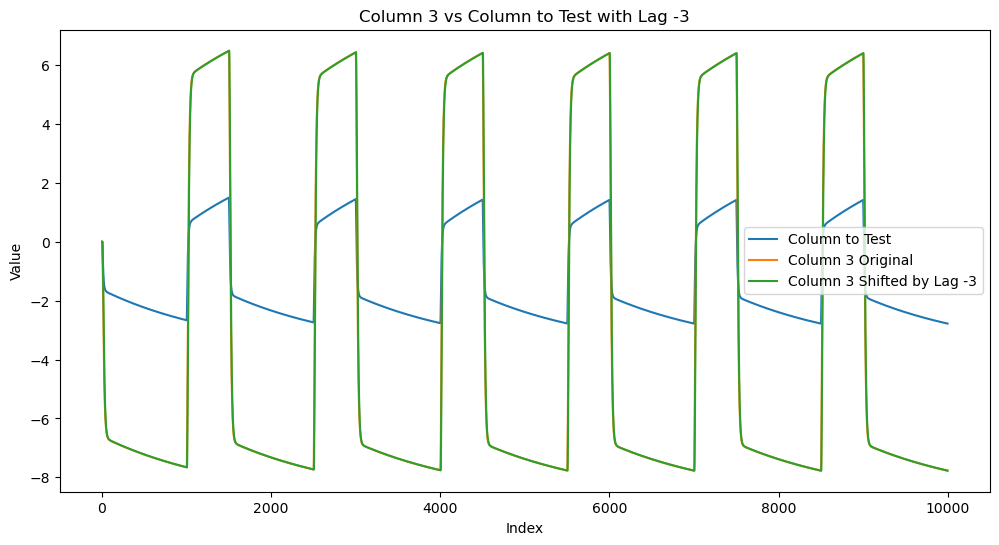

In [13]:
import numpy as np
import matplotlib.pyplot as plt


column2test_index = 2
column2test = data_array[:, column2test_index]

# Define the lag range from -300 to 300 inclusive
lag_range = np.arange(-300, 301)

# Prepare lists to store the maximum correlations and corresponding lags
max_correlations = []
max_lags = []

# Loop over the other columns
for col_index in range(data_array.shape[1]):
    if col_index == column2test_index:
        continue  # Skip the column to test

    compared_column = data_array[:, col_index]
    correlations = []

    # Compute correlations for each lag
    for lag in lag_range:
        if lag < 0:
            # Negative lag: shift compared column to the right
            shifted_compared = compared_column[-lag:]  # Discard first -lag elements
            fixed_column = column2test[:lag]           # Discard last -lag elements
        elif lag > 0:
            # compared column is shifted to the left
            # Positive lag: shift compared column to the left
            shifted_compared = compared_column[:-lag]  # Discard last lag elements
            fixed_column = column2test[lag:]           # Discard first lag elements
        else:
            shifted_compared = compared_column
            fixed_column = column2test

        # Ensure the arrays are of the same length
        if len(shifted_compared) == len(fixed_column):
            corr = np.corrcoef(fixed_column, shifted_compared)[0, 1]
            correlations.append(corr)
        else:
            correlations.append(0)  # Handle mismatched lengths

    # Find the lag that maximizes the correlation
    max_corr_index = np.argmax(correlations)
    max_corr = correlations[max_corr_index]
    max_lag = lag_range[max_corr_index]

    max_correlations.append(max_corr)
    max_lags.append(max_lag)

    print(f"Column {col_index}: Max correlation at lag {max_lag} with value {max_corr}")

    # Plotting
    plt.figure(figsize=(12, 6))
    plt.plot(range(len(column2test)), column2test, label='Column to Test')

    plt.plot(range(len(compared_column)), compared_column, label=f'Column {col_index} Original')

    # Shift the compared column according to the calculated lag for plotting
    if max_lag < 0:
        # Shift right: pad with NaN at the start
        shifted_compared_column = np.concatenate((
            np.full(-max_lag, np.nan),
            compared_column[:max_lag]
        ))
    elif max_lag > 0:
        # Shift left: pad with NaN at the end
        shifted_compared_column = np.concatenate((
            compared_column[max_lag:],
            np.full(max_lag, np.nan)
        ))
    else:
        shifted_compared_column = compared_column

    plt.plot(range(len(shifted_compared_column)), shifted_compared_column,
             label=f'Column {col_index} Shifted by Lag {max_lag}')

    plt.legend()
    plt.title(f'Column {col_index} vs Column to Test with Lag {max_lag}')
    plt.xlabel('Index')
    plt.ylabel('Value')
    plt.show()


# PCMCI using differenciated data

(<Figure size 640x480 with 4 Axes>,
 array([<Axes: ylabel='Box 1'>, <Axes: ylabel='Box 2'>,
        <Axes: ylabel='Box 3'>, <Axes: ylabel='Box 4'>], dtype=object))

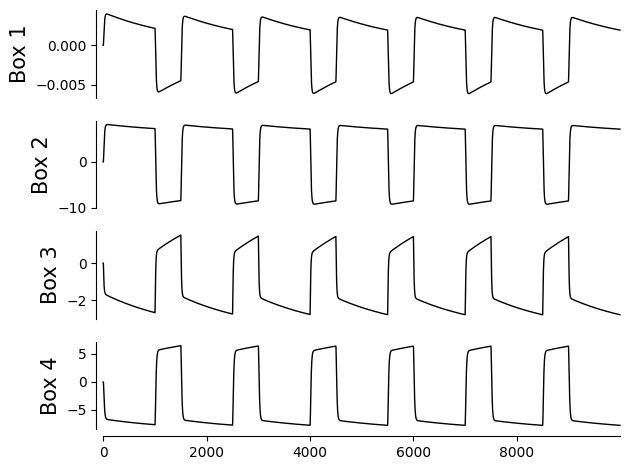

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import tigramite
from tigramite import data_processing as pp
from tigramite import plotting as tp
from tigramite.pcmci import PCMCI
from tigramite.independence_tests import parcorr, gpdc, cmiknn
import pandas as pd

idx = 9  # Index of the last simulation without noise
# Convert the dictionary to an array suitable for Tigramite's DataFrame
data_array = Temps[idx, 0, 1:5, :].T.copy()

# For data_array, for the first column, replace it with its derivative
first_col_diff = np.diff(data_array[:, 0])
# drop the last row of data_array
data_array = data_array[:-1, :]
# replace the first column with the derivative
data_array[:, 0] = first_col_diff


# Create a Tigramite DataFrame object
var_names = [f"Box {k+1}" for k in range(4)]

# create adataframe called 'df4stationary_check' with the data_array and the variable names
df4stationary_check= pd.DataFrame(data_array, columns=var_names)

dataframe_TEMP = pp.DataFrame(data_array, datatime=np.arange(data_array.shape[0]), var_names=var_names)
tp.plot_timeseries(dataframe_TEMP,label_fontsize=15,tick_label_size=10)

In [28]:
from toolbox import GC_functions as GC  # Assuming GC_functions is your custom module


df4stationary_check = GC.make_stationary(df4stationary_check,['Box 1', 'Box 2', 'Box 3','Box 4'], test_method='ADF', plot=True,print_results=True)
# df4stationary_check

ADF Statistic: -4.079669776911218
p-value: 0.0010462409456072424
Critical Values:
	1%: -3.4310043597505673
	5%: -2.8618291880722437
	10%: -2.5669239296731097
The series is stationary.
Series in column 'Box 1' is stationary after 0 differencing operation(s).
ADF Statistic: -4.080626206314961
p-value: 0.0010424577488466371
Critical Values:
	1%: -3.4310043597505673
	5%: -2.8618291880722437
	10%: -2.5669239296731097
The series is stationary.
Series in column 'Box 2' is stationary after 0 differencing operation(s).
ADF Statistic: -3.77347165570788
p-value: 0.003190699931387761
Critical Values:
	1%: -3.4310043597505673
	5%: -2.8618291880722437
	10%: -2.5669239296731097
The series is stationary.
Series in column 'Box 3' is stationary after 0 differencing operation(s).
ADF Statistic: -3.7759800413029776
p-value: 0.003162856228396897
Critical Values:
	1%: -3.431004556246501
	5%: -2.8618292749021865
	10%: -2.5669239758928017
The series is stationary.
Series in column 'Box 4' is stationary after 


##
## Step 1: PC1 algorithm for selecting lagged conditions
##

Parameters:
independence test = par_corr
tau_min = 1
tau_max = 2
pc_alpha = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
max_conds_dim = None
max_combinations = 1



## Resulting lagged parent (super)sets:

    Variable Box 1 has 0 link(s):
    [pc_alpha = 0.05]

    Variable Box 2 has 2 link(s):
    [pc_alpha = 0.2]
        (Box 2 -1): max_pval = 0.00000, |min_val| =  0.066
        (Box 1 -1): max_pval = 0.15514, |min_val| =  0.014

    Variable Box 3 has 0 link(s):
    [pc_alpha = 0.05]

    Variable Box 4 has 3 link(s):
    [pc_alpha = 0.3]
        (Box 2 -1): max_pval = 0.00832, |min_val| =  0.026
        (Box 1 -2): max_pval = 0.07670, |min_val| =  0.018
        (Box 1 -1): max_pval = 0.27948, |min_val| =  0.011

##
## Step 2: MCI algorithm
##

Parameters:

independence test = par_corr
tau_min = 1
tau_max = 2
max_conds_py = None
max_conds_px = None

## Significant links at alpha = 0.05:

    Variable Box 1 has 8 link(s):
        

(<Figure size 2000x2000 with 1 Axes>, <Axes: >)

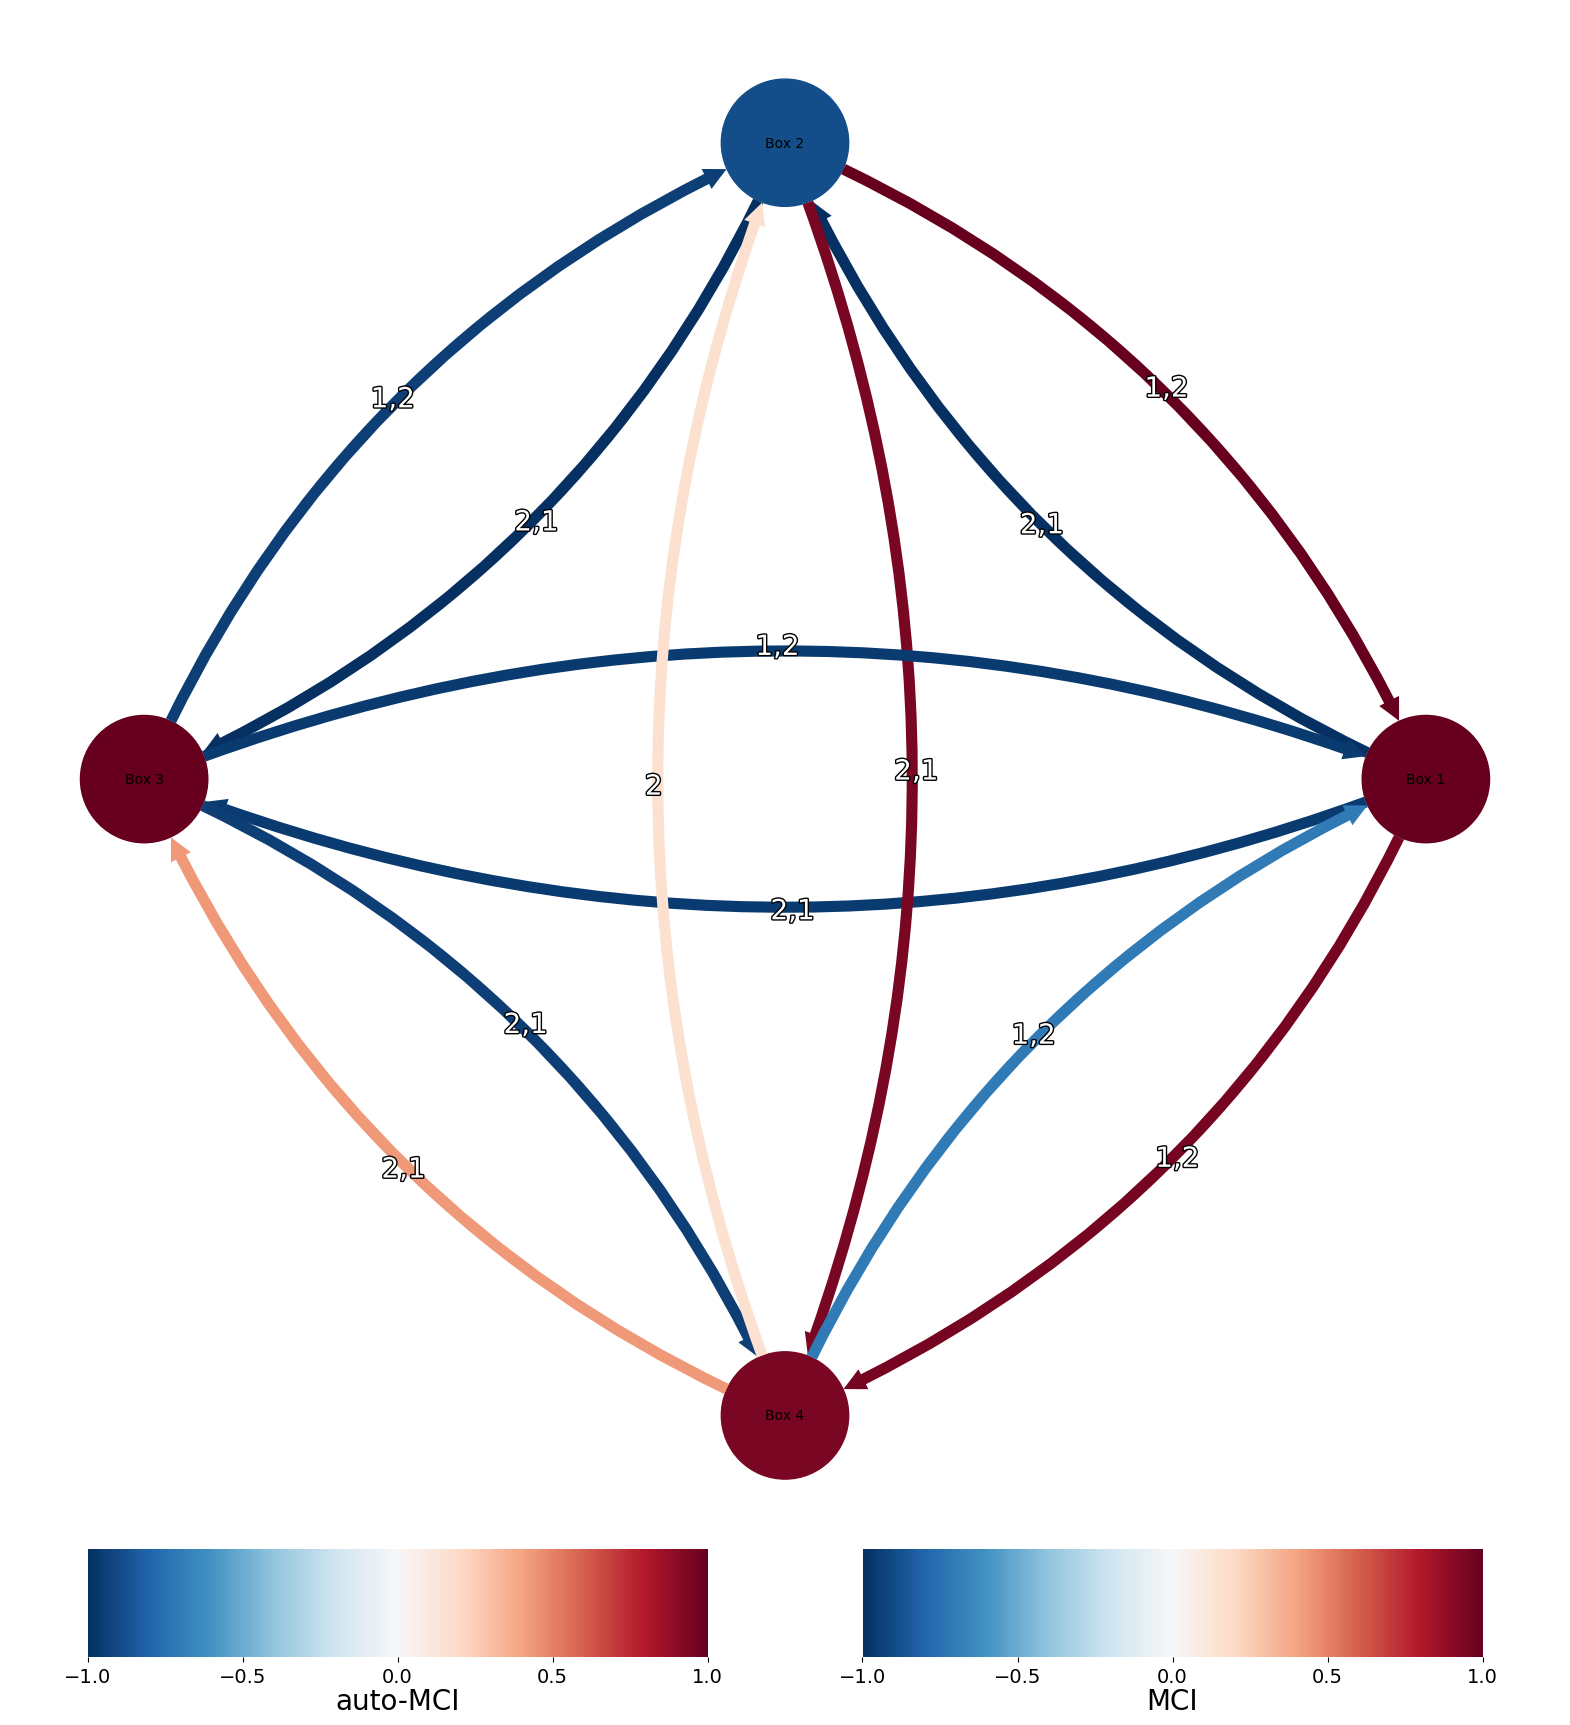

In [8]:
ParCorr = parcorr.ParCorr(significance='analytic')
pcmci = PCMCI(
    dataframe=dataframe_TEMP,
    cond_ind_test=ParCorr,
    verbosity=1)

pcmci.verbosity = 1
tau_min=1
tau_max=2
results = pcmci.run_pcmci(tau_min=tau_min, tau_max=tau_max, pc_alpha=None)
# q_matrix = pcmci.get_corrected_pvalues(p_matrix=results['p_matrix'], tau_max=tau_max, fdr_method='fdr_bh')

# create a figure
fig, ax = plt.subplots(1, 1, figsize=(20, 20), dpi=100)
tp.plot_graph(
    fig_ax=(fig, ax),
    graph = results['graph'],
    val_matrix=results['val_matrix'],
    var_names=var_names,
    link_colorbar_label='MCI',
    node_colorbar_label='auto-MCI',
    link_label_fontsize=20,
    label_fontsize=20,
    tick_label_size=14,
    node_label_size=10,
    edge_ticks=0.5,
    node_ticks=0.5,
    node_size=0.2
    )

In [4]:
Temps.shape

(10, 1, 6, 10000)

In [7]:
df4stationary_check.info

<bound method DataFrame.info of          Box 1     Box 2     Box 3     Box 4
0     0.000000  0.000000  0.000000  0.000000
1     0.000000  0.000000  0.000000  0.000000
2     0.000000  0.000000  0.000000  0.000000
3     0.000050  0.100000 -0.050000 -0.050000
4     0.000137  0.274950 -0.130000 -0.145000
...        ...       ...       ...       ...
9994  0.001951  7.210575 -2.776346 -7.769674
9995  0.001950  7.209932 -2.776998 -7.770330
9996  0.001949  7.209290 -2.777649 -7.770985
9997  0.001947  7.208648 -2.778299 -7.771640
9998  0.001946  7.208006 -2.778949 -7.772295

[9999 rows x 4 columns]>

# Data with noise


##
## Step 1: PC1 algorithm for selecting lagged conditions
##

Parameters:
independence test = par_corr
tau_min = 1
tau_max = 2
pc_alpha = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
max_conds_dim = None
max_combinations = 1



## Resulting lagged parent (super)sets:

    Variable Box 1 has 1 link(s):
    [pc_alpha = 0.2]
        (Box 1 -2): max_pval = 0.10247, |min_val| =  0.016

    Variable Box 2 has 6 link(s):
    [pc_alpha = 0.3]
        (Box 2 -1): max_pval = 0.00000, |min_val| =  0.807
        (Box 2 -2): max_pval = 0.00000, |min_val| =  0.529
        (Box 3 -2): max_pval = 0.00000, |min_val| =  0.069
        (Box 3 -1): max_pval = 0.00124, |min_val| =  0.032
        (Box 4 -2): max_pval = 0.05794, |min_val| =  0.019
        (Box 4 -1): max_pval = 0.20440, |min_val| =  0.013

    Variable Box 3 has 5 link(s):
    [pc_alpha = 0.2]
        (Box 3 -1): max_pval = 0.00000, |min_val| =  0.767
        (Box 3 -2): max_pval = 0.00000, |min_val| =  0.538
        (Box 4 -1): max_pval = 0.00000, |mi

(<Figure size 2000x2000 with 1 Axes>, <Axes: >)

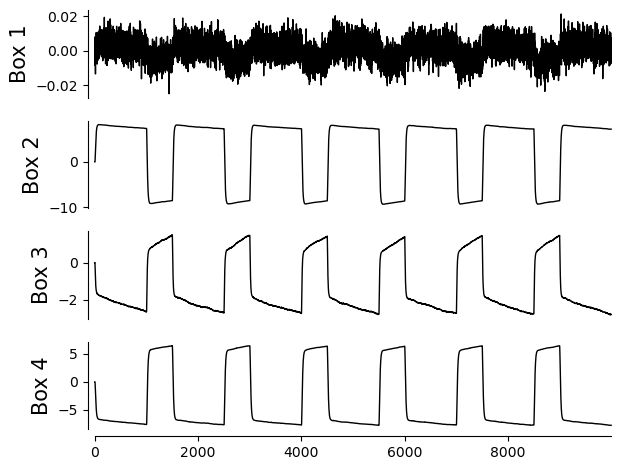

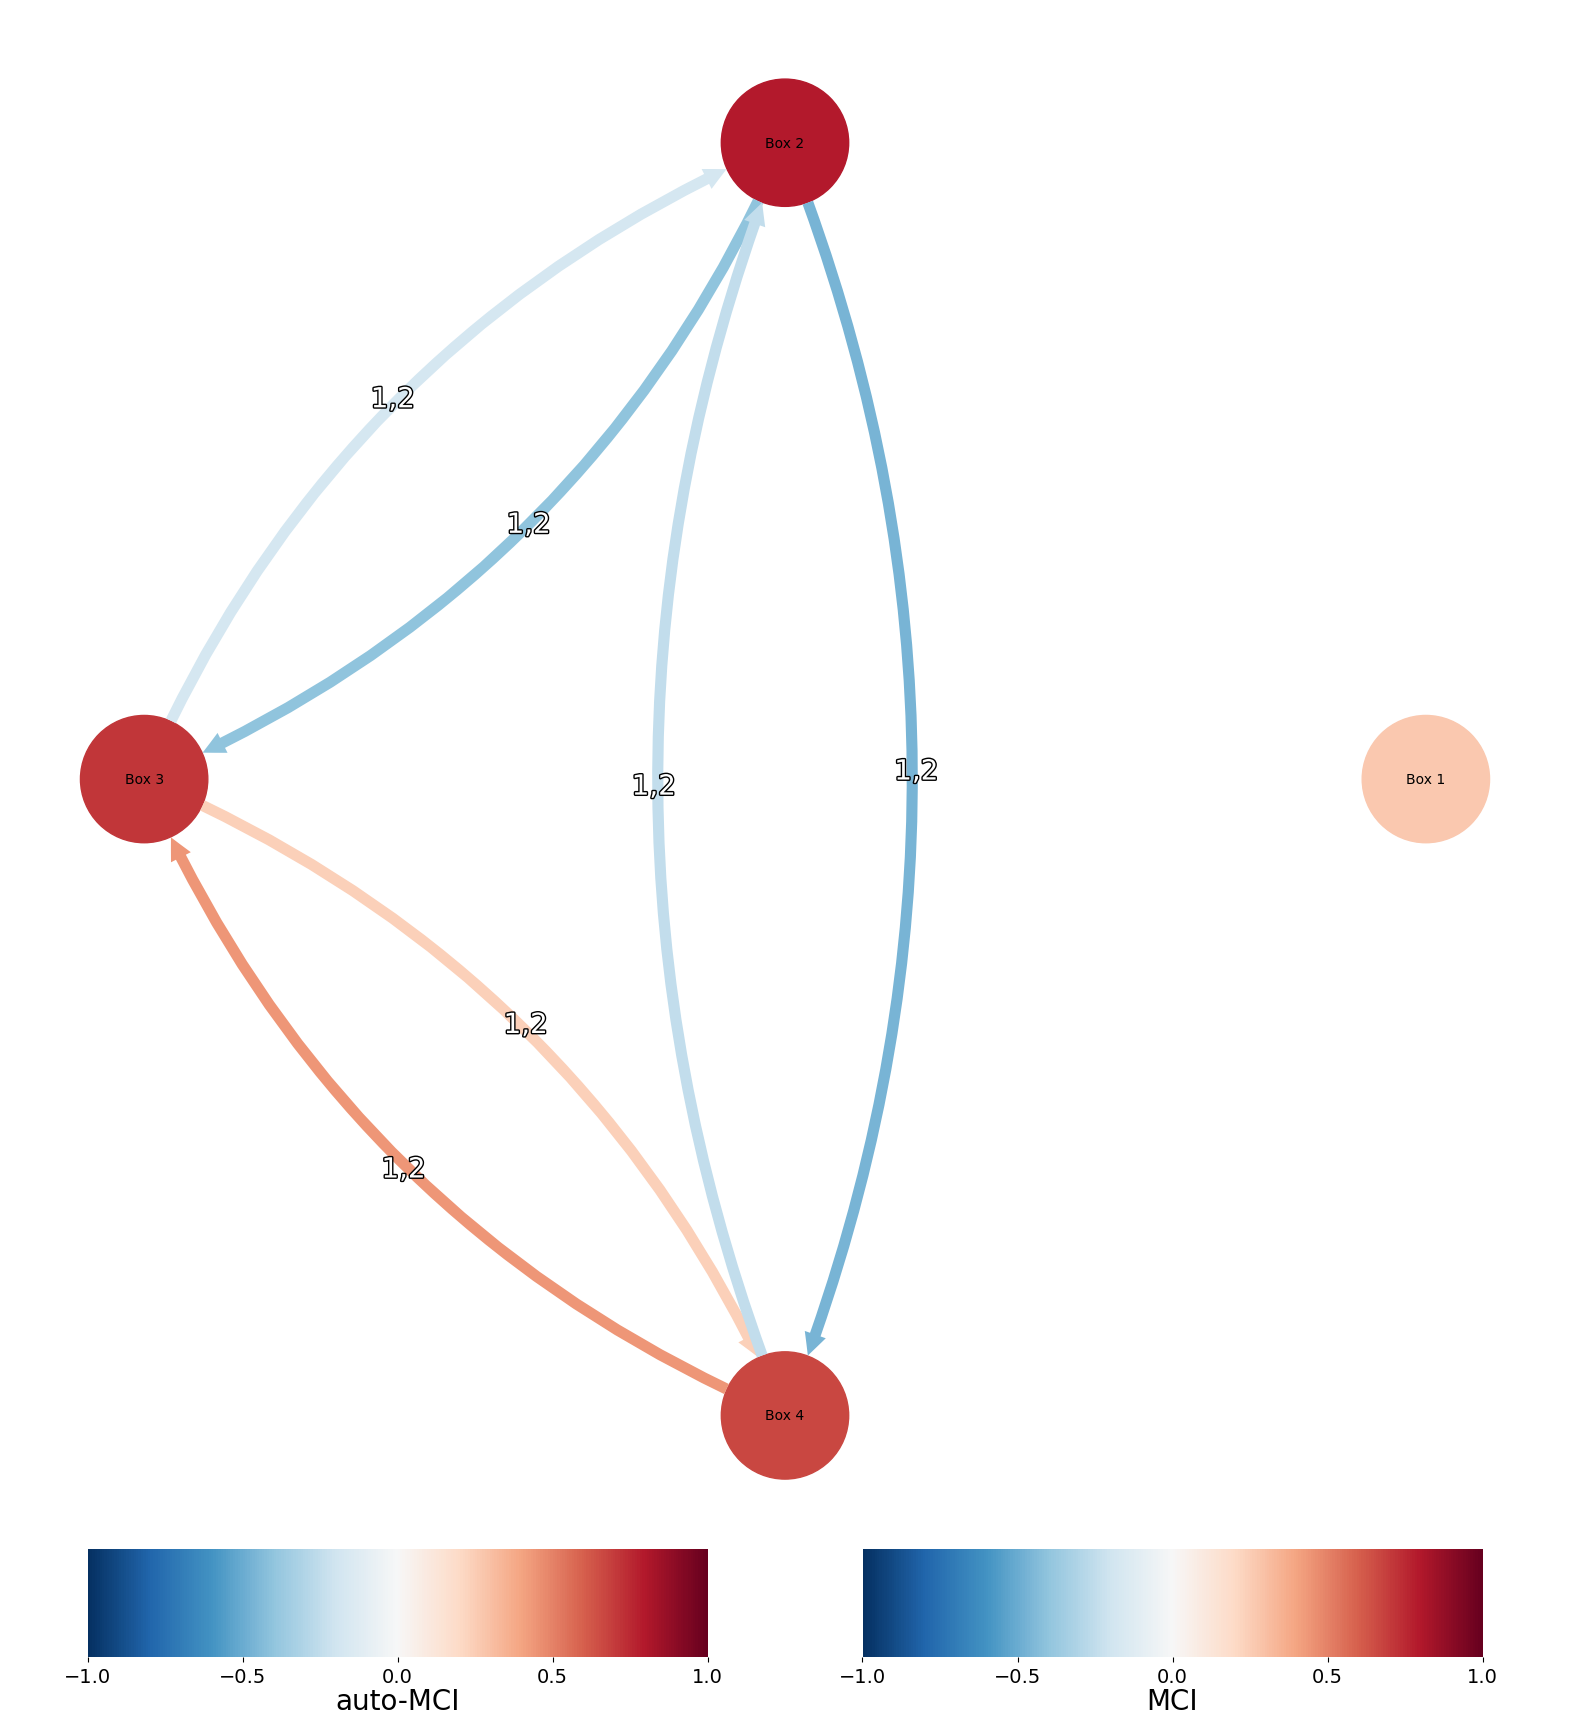

In [20]:
import numpy as np
import matplotlib.pyplot as plt
import tigramite
from tigramite import data_processing as pp
from tigramite import plotting as tp
from tigramite.pcmci import PCMCI
from tigramite.independence_tests import parcorr, gpdc, cmiknn
import pandas as pd

idx = 0  # Index of the last simulation without noise
# Convert the dictionary to an array suitable for Tigramite's DataFrame
data_array = Temps[idx, 0, 1:5, :].T.copy()

# For data_array, for the first column, replace it with its derivative
first_col_diff = np.diff(data_array[:, 0])
# drop the last row of data_array
data_array = data_array[:-1, :]
# replace the first column with the derivative
data_array[:, 0] = first_col_diff


# Create a Tigramite DataFrame object
var_names = [f"Box {k+1}" for k in range(4)]

# create adataframe called 'df4stationary_check' with the data_array and the variable names
df4stationary_check= pd.DataFrame(data_array, columns=var_names)

dataframe_TEMP = pp.DataFrame(data_array, datatime=np.arange(data_array.shape[0]), var_names=var_names)
tp.plot_timeseries(dataframe_TEMP,label_fontsize=15,tick_label_size=10)
ParCorr = parcorr.ParCorr(significance='analytic')
pcmci = PCMCI(
    dataframe=dataframe_TEMP,
    cond_ind_test=ParCorr,
    verbosity=1)

pcmci.verbosity = 1
tau_max=2
results = pcmci.run_pcmci(tau_min=1, tau_max=tau_max, pc_alpha=None)
# q_matrix = pcmci.get_corrected_pvalues(p_matrix=results['p_matrix'], tau_max=tau_max, fdr_method='fdr_bh')

# create a figure
fig, ax = plt.subplots(1, 1, figsize=(20, 20), dpi=100)
tp.plot_graph(
    fig_ax=(fig, ax),
    graph = results['graph'],
    val_matrix=results['val_matrix'],
    var_names=var_names,
    link_colorbar_label='MCI',
    node_colorbar_label='auto-MCI',
    link_label_fontsize=20,
    label_fontsize=20,
    tick_label_size=14,
    node_label_size=10,
    edge_ticks=0.5,
    node_ticks=0.5,
    node_size=0.2
    )

# PCMCI using normalized data

In [10]:
from toolbox import OneDModel_TBK as ODM
import importlib
importlib.reload(ODM)

Temps, F, Fadv = ODM.OneDModel(show_figures=False)



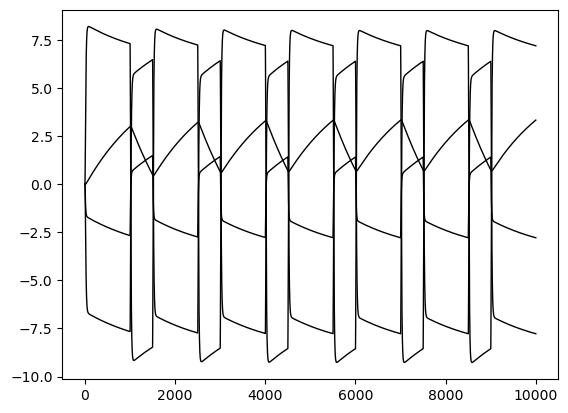

In [11]:
import matplotlib.pyplot as plt
import numpy as np



time = np.arange(1, len(np.squeeze(Temps[0, 0, 1, :])) + 1)

plt.figure()
idx=9
# Last loop (i == 10), plot in black
plt.plot(time, Temps[idx, 0, 1, :], 'k', linewidth=1)
plt.plot(time, Temps[idx, 0, 2, :], 'k', linewidth=1)
plt.plot(time, Temps[idx, 0, 3, :], 'k', linewidth=1)
plt.plot(time, Temps[idx, 0, 4, :], 'k', linewidth=1)

(<Figure size 640x480 with 4 Axes>,
 array([<Axes: ylabel='Box 1'>, <Axes: ylabel='Box 2'>,
        <Axes: ylabel='Box 3'>, <Axes: ylabel='Box 4'>], dtype=object))

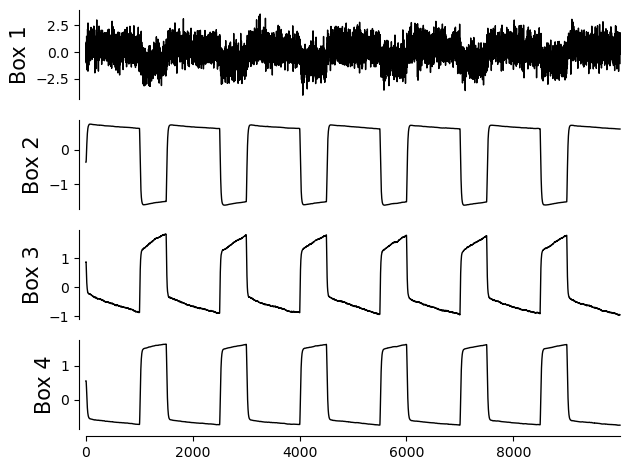

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import tigramite
from tigramite import data_processing as pp
from tigramite import plotting as tp
from tigramite.pcmci import PCMCI
from tigramite.independence_tests import parcorr, gpdc, cmiknn
import pandas as pd

idx = 0  # Index of the last simulation without noise
# Convert the dictionary to an array suitable for Tigramite's DataFrame
data_array = Temps[idx, 0, 1:5, :].T.copy()

# For data_array, for the first column, replace it with its derivative
first_col_diff = np.diff(data_array[:, 0])
# drop the last row of data_array
data_array = data_array[:-1, :]
# replace the first column with the derivative
data_array[:, 0] = first_col_diff

# normalize the data_array
data_array = (data_array - np.mean(data_array, axis=0)) / np.std(data_array, axis=0)

# Create a Tigramite DataFrame object
var_names = [f"Box {k+1}" for k in range(4)]

# create adataframe called 'df4stationary_check' with the data_array and the variable names
df4stationary_check= pd.DataFrame(data_array, columns=var_names)

dataframe_TEMP = pp.DataFrame(data_array, datatime=np.arange(data_array.shape[0]), var_names=var_names)
tp.plot_timeseries(dataframe_TEMP,label_fontsize=15,tick_label_size=10)


##
## Step 1: PC1 algorithm for selecting lagged conditions
##

Parameters:
independence test = par_corr
tau_min = 1
tau_max = 2
pc_alpha = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
max_conds_dim = None
max_combinations = 1



## Resulting lagged parent (super)sets:

    Variable Box 1 has 4 link(s):
    [pc_alpha = 0.05]
        (Box 4 -1): max_pval = 0.00000, |min_val| =  0.078
        (Box 4 -2): max_pval = 0.00000, |min_val| =  0.067
        (Box 2 -1): max_pval = 0.01826, |min_val| =  0.024
        (Box 2 -2): max_pval = 0.02586, |min_val| =  0.022

    Variable Box 2 has 6 link(s):
    [pc_alpha = 0.3]
        (Box 2 -1): max_pval = 0.00000, |min_val| =  0.803
        (Box 2 -2): max_pval = 0.00000, |min_val| =  0.522
        (Box 3 -2): max_pval = 0.00000, |min_val| =  0.069
        (Box 3 -1): max_pval = 0.00180, |min_val| =  0.031
        (Box 4 -2): max_pval = 0.07963, |min_val| =  0.018
        (Box 4 -1): max_pval = 0.26019, |min_val| =  0.011

    Variable Box 3 has 7 link(s):
    

(<Figure size 2000x2000 with 1 Axes>, <Axes: >)

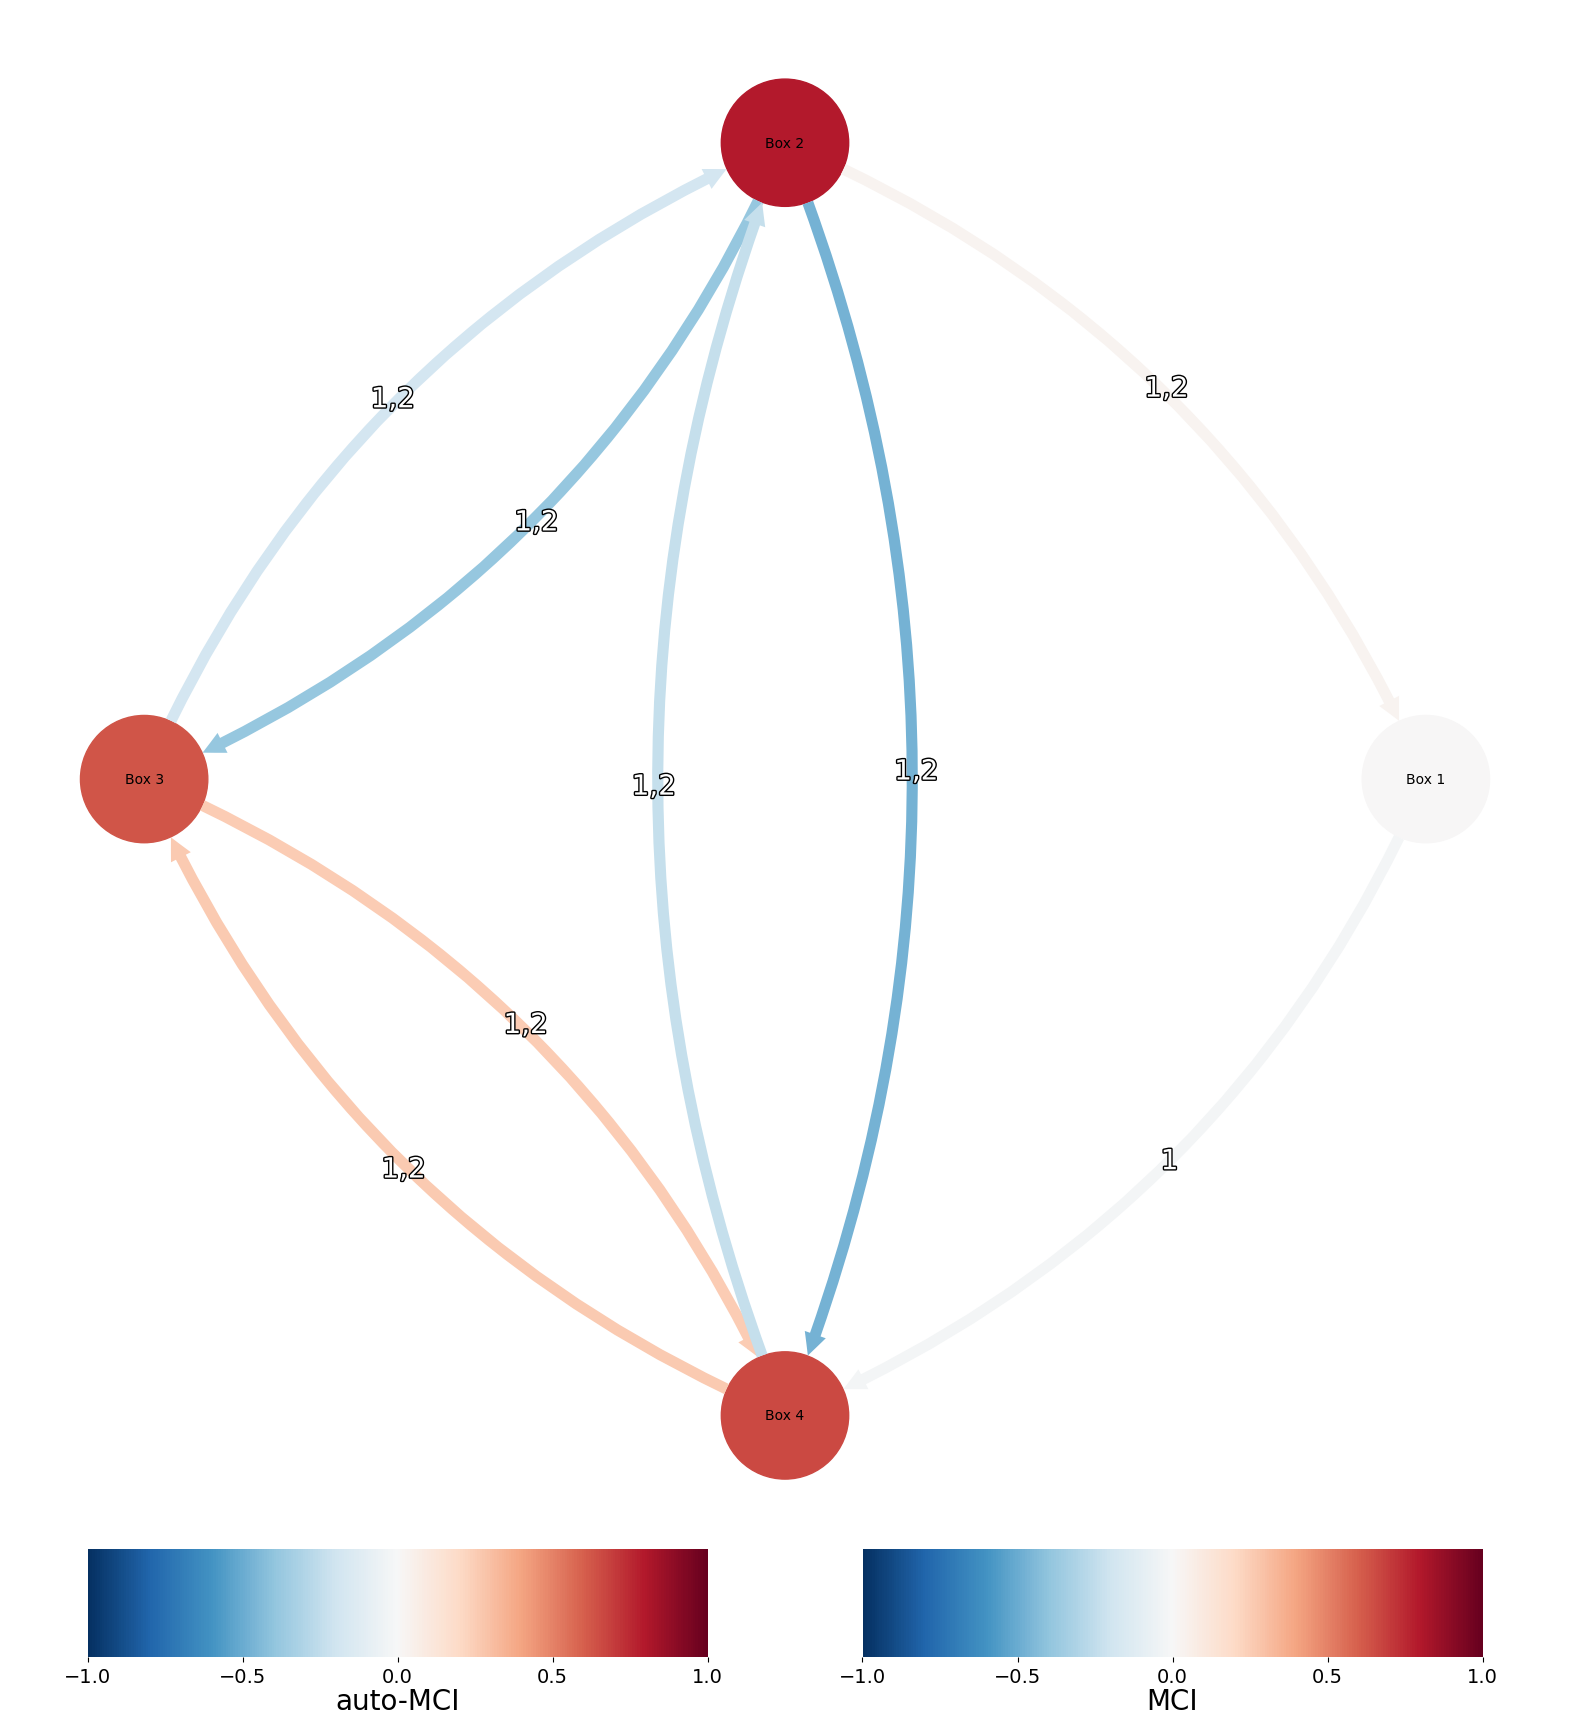

In [16]:
ParCorr = parcorr.ParCorr(significance='analytic')
pcmci = PCMCI(
    dataframe=dataframe_TEMP,
    cond_ind_test=ParCorr,
    verbosity=1)

pcmci.verbosity = 1
tau_max=2
results = pcmci.run_pcmci(tau_min=1, tau_max=tau_max, pc_alpha=None)
# q_matrix = pcmci.get_corrected_pvalues(p_matrix=results['p_matrix'], tau_max=tau_max, fdr_method='fdr_bh')

# create a figure
fig, ax = plt.subplots(1, 1, figsize=(20, 20), dpi=100)
tp.plot_graph(
    fig_ax=(fig, ax),
    graph = results['graph'],
    val_matrix=results['val_matrix'],
    var_names=var_names,
    link_colorbar_label='MCI',
    node_colorbar_label='auto-MCI',
    link_label_fontsize=20,
    label_fontsize=20,
    tick_label_size=14,
    node_label_size=10,
    edge_ticks=0.5,
    node_ticks=0.5,
    node_size=0.2
    )

# The pair plot

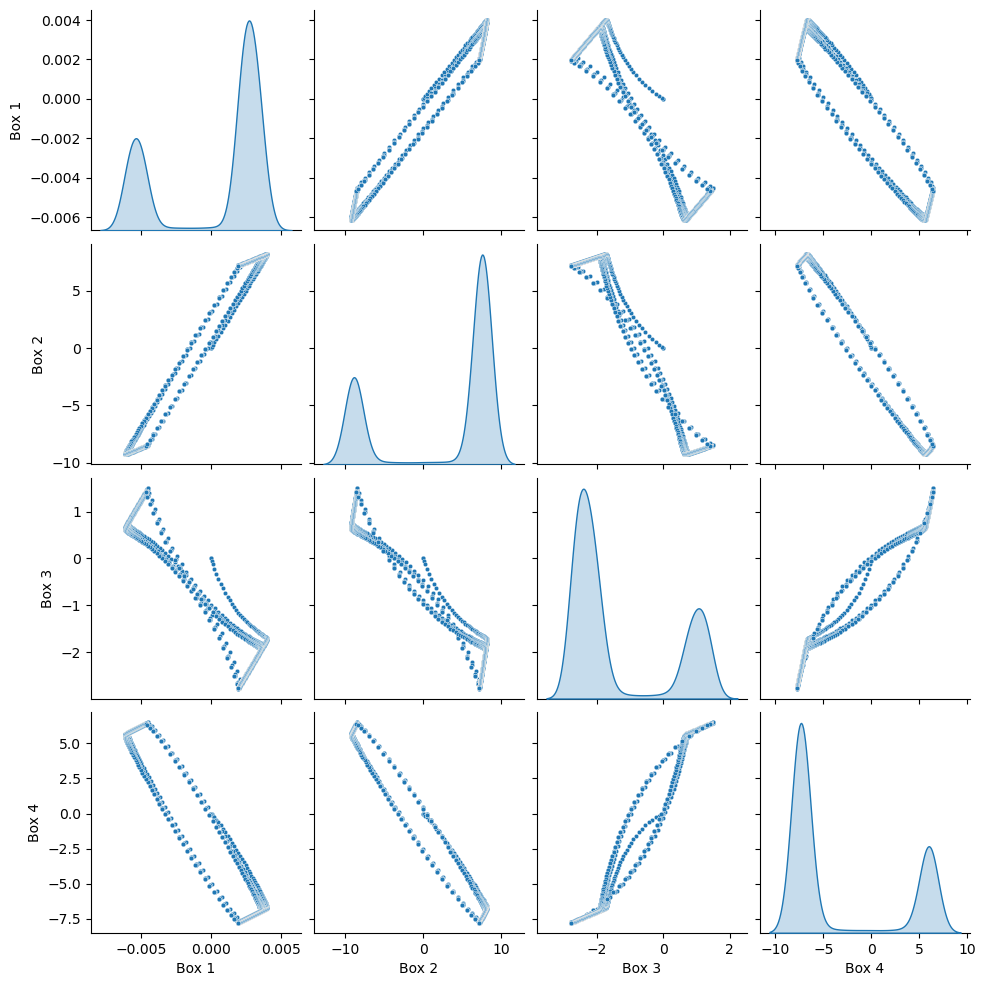

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

# Ensure that the DataFrame only contains the columns you want to plot
columns_to_plot = ['Box 1', 'Box 2', 'Box 3', 'Box 4']
data_to_plot = df4stationary_check[columns_to_plot]

# Create pairplot
sns.pairplot(data_to_plot, diag_kind='kde', plot_kws={'s': 10})

# Display the plots
plt.show()


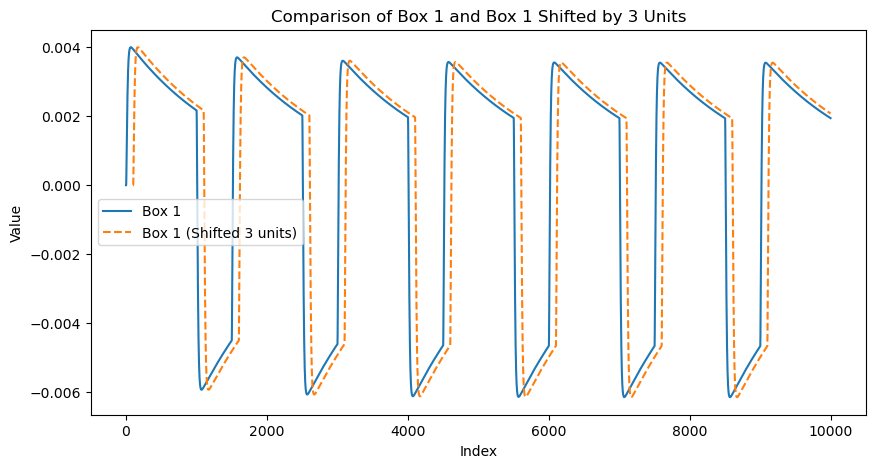

In [16]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Create the figure
fig, ax = plt.subplots(figsize=(10, 5))

# Original Box 1
ax.plot(df4stationary_check['Box 1'], label='Box 1')

# Box 1 shifted by 3 units
ax.plot(df4stationary_check['Box 1'].shift(100), label='Box 1 (Shifted 3 units)', linestyle='--')

# Adding labels and legend
ax.set_title('Comparison of Box 1 and Box 1 Shifted by 3 Units')
ax.set_xlabel('Index')
ax.set_ylabel('Value')
ax.legend()

plt.show()


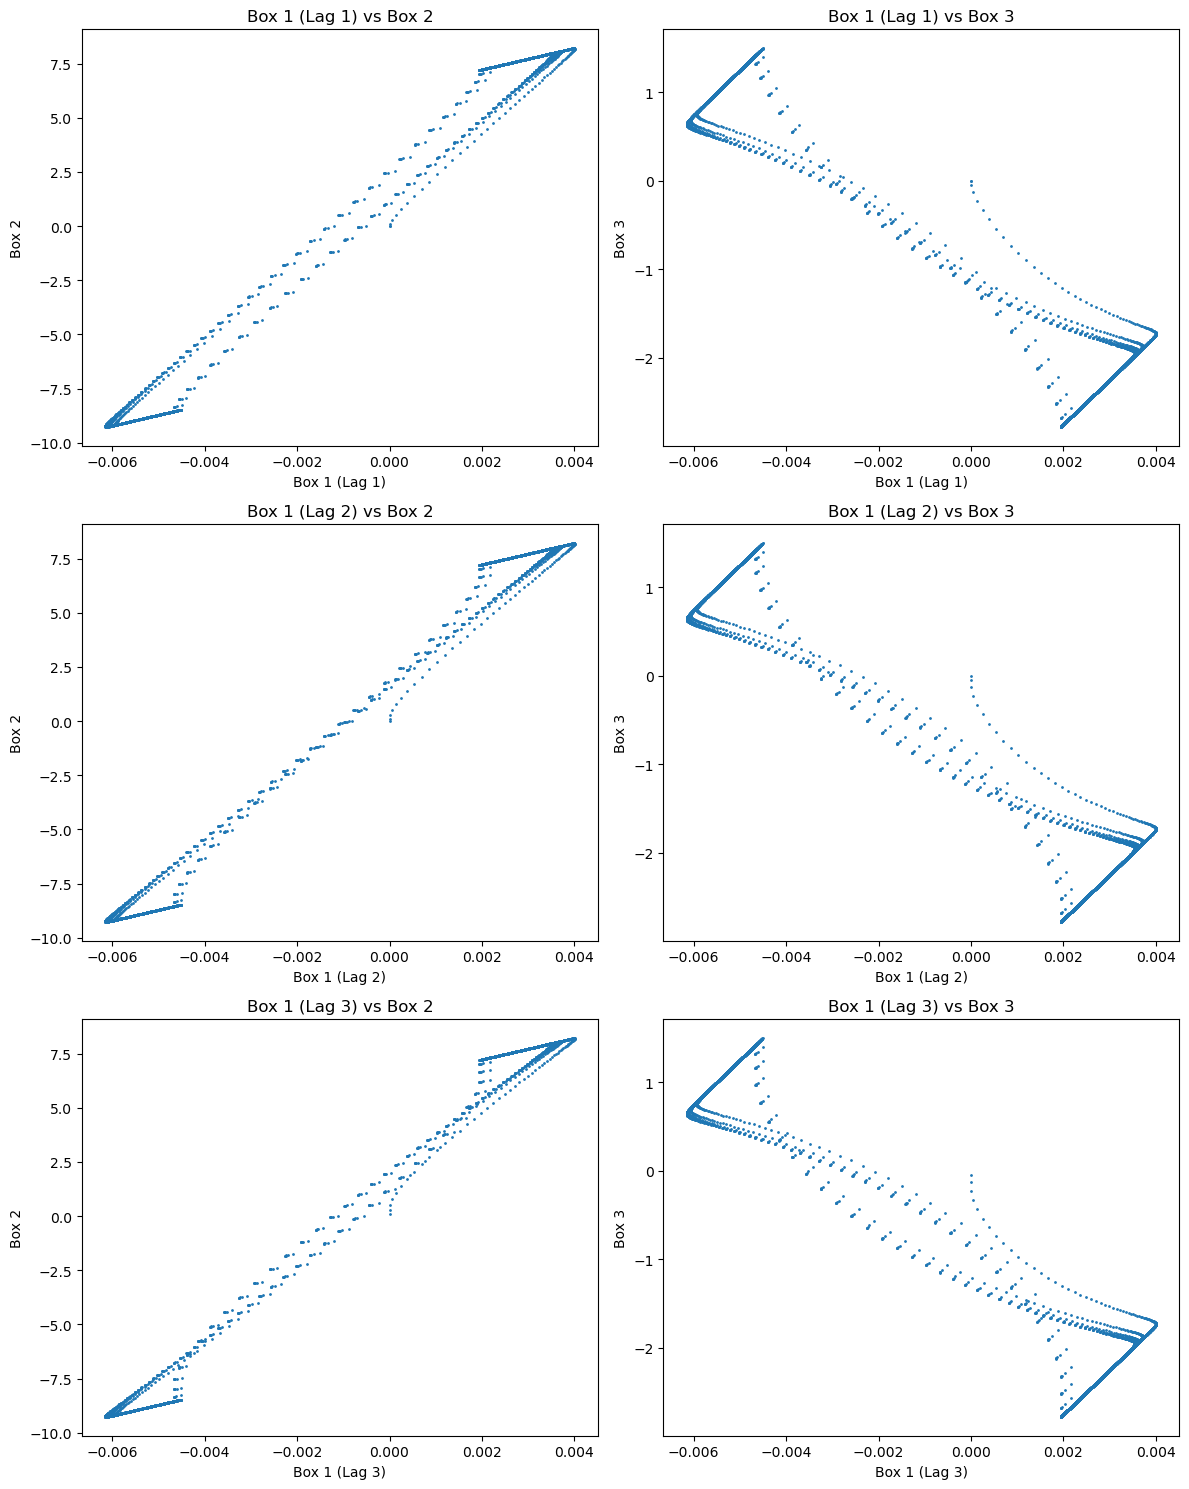

In [11]:
import matplotlib.pyplot as plt

# Create the figure with 3 rows and 2 columns
fig, axs = plt.subplots(3, 2, figsize=(12, 15))

# Iterate over each row to plot different lags
for i in range(3):
    lag = i + 1  # Lag 1, 2, and 3
    
    # Box 1 lagged vs Box 2
    axs[i, 0].scatter(df4stationary_check['Box 1'].shift(lag), df4stationary_check['Box 2'], s=1)
    axs[i, 0].set_xlabel(f'Box 1 (Lag {lag})')
    axs[i, 0].set_ylabel('Box 2')
    axs[i, 0].set_title(f'Box 1 (Lag {lag}) vs Box 2')
    
    # Box 1 lagged vs Box 3
    axs[i, 1].scatter(df4stationary_check['Box 1'].shift(lag), df4stationary_check['Box 3'], s=1)
    axs[i, 1].set_xlabel(f'Box 1 (Lag {lag})')
    axs[i, 1].set_ylabel('Box 3')
    axs[i, 1].set_title(f'Box 1 (Lag {lag}) vs Box 3')

plt.tight_layout()
plt.show()


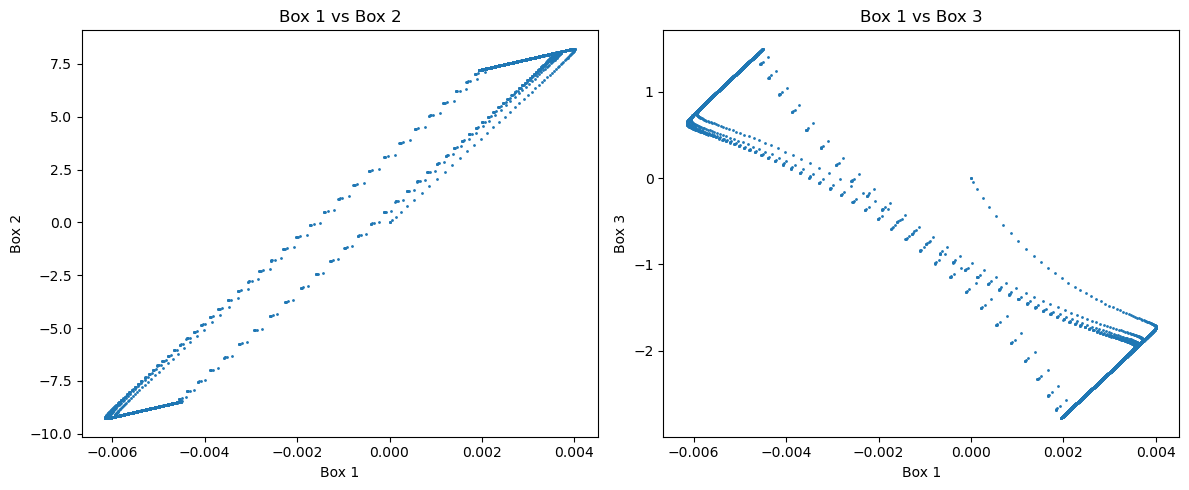

In [8]:
import matplotlib.pyplot as plt

# Plot settings
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Box 1 vs Box 2
axs[0].scatter(df4stationary_check['Box 1'], df4stationary_check['Box 2'], s=1)
axs[0].set_xlabel('Box 1')
axs[0].set_ylabel('Box 2')
axs[0].set_title('Box 1 vs Box 2')

# Box 1 vs Box 3
axs[1].scatter(df4stationary_check['Box 1'], df4stationary_check['Box 3'], s=1)
axs[1].set_xlabel('Box 1')
axs[1].set_ylabel('Box 3')
axs[1].set_title('Box 1 vs Box 3')

plt.tight_layout()
plt.show()


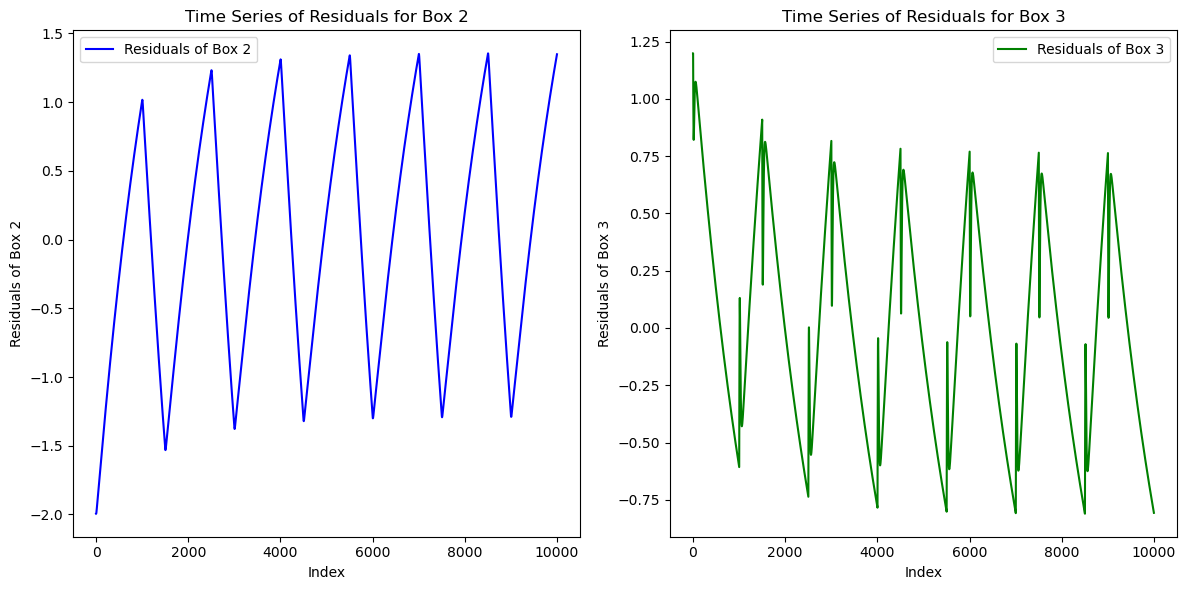

In [19]:
import matplotlib.pyplot as plt
import statsmodels.api as sm

# Assuming df4stationary_check is predefined and contains 'Box 1', 'Box 2', 'Box 3'
# Linear regression of Box 2 over Box 1
X = sm.add_constant(df4stationary_check['Box 1'])  # Adds a constant term to the predictor
Y_box2 = df4stationary_check['Box 2']
model_box2 = sm.OLS(Y_box2, X).fit()
residuals_box2 = model_box2.resid

# Linear regression of Box 3 over Box 1
Y_box3 = df4stationary_check['Box 3']
model_box3 = sm.OLS(Y_box3, X).fit()
residuals_box3 = model_box3.resid

# Create the figure with two subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plotting residuals of Box 2 as a time series
axs[0].plot(residuals_box2, label='Residuals of Box 2', color='blue')
axs[0].set_title('Time Series of Residuals for Box 2')
axs[0].set_xlabel('Index')
axs[0].set_ylabel('Residuals of Box 2')
axs[0].legend()

# Plotting residuals of Box 3 as a time series
axs[1].plot(residuals_box3, label='Residuals of Box 3', color='green')
axs[1].set_title('Time Series of Residuals for Box 3')
axs[1].set_xlabel('Index')
axs[1].set_ylabel('Residuals of Box 3')
axs[1].legend()

plt.tight_layout()
plt.show()


Parameters index: Index(['const', 0], dtype='object')
P-values index: Index(['const', 0], dtype='object')


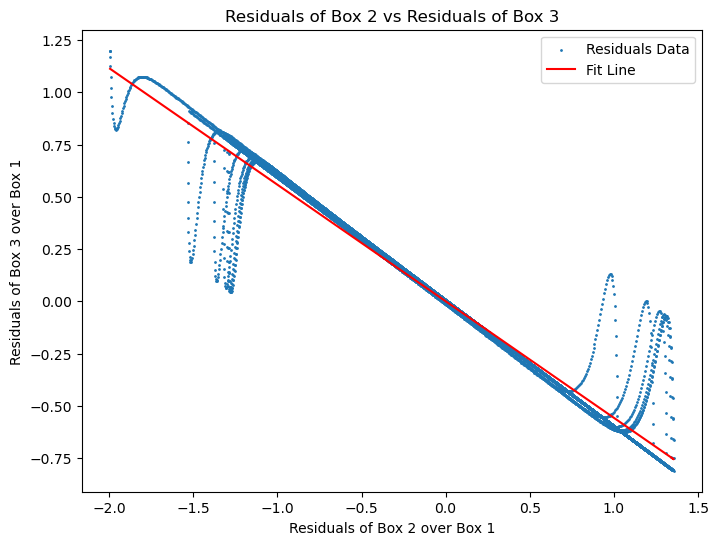

Slope of the fit: -0.5577792993813542
P-value of the fit: 0.0


In [20]:
import statsmodels.api as sm

# # Linear regression of Box 2 over Box 1
# X = sm.add_constant(df4stationary_check['Box 1'])  # Adds a constant term to the predictor
# Y_box2 = df4stationary_check['Box 2']
# model_box2 = sm.OLS(Y_box2, X).fit()
# residuals_box2 = model_box2.resid

# # Linear regression of Box 3 over Box 1
# Y_box3 = df4stationary_check['Box 3']
# model_box3 = sm.OLS(Y_box3, X).fit()
# residuals_box3 = model_box3.resid

# Linear regression of residuals
X_resid = sm.add_constant(residuals_box2)
model_resid = sm.OLS(residuals_box3, X_resid).fit()

# Access the slope and p-value using .iloc
slope = model_resid.params.iloc[1]
p_value = model_resid.pvalues.iloc[1]

# Alternatively, print the index to see the correct labels
print("Parameters index:", model_resid.params.index)
print("P-values index:", model_resid.pvalues.index)

# Plotting the residuals
plt.figure(figsize=(8, 6))
plt.scatter(residuals_box2, residuals_box3, s=1, label='Residuals Data')
plt.plot(residuals_box2, model_resid.predict(X_resid), color='red', label='Fit Line')
plt.xlabel('Residuals of Box 2 over Box 1')
plt.ylabel('Residuals of Box 3 over Box 1')
plt.title('Residuals of Box 2 vs Residuals of Box 3')
plt.legend()
plt.show()

# Displaying the slope and p-value
print(f"Slope of the fit: {slope}")
print(f"P-value of the fit: {p_value}")


In [6]:
from toolbox import OneDModel_TBK as ODM
import importlib
importlib.reload(ODM)

Temps_ori, F, Fadv = ODM.OneDModel(show_figures=False)



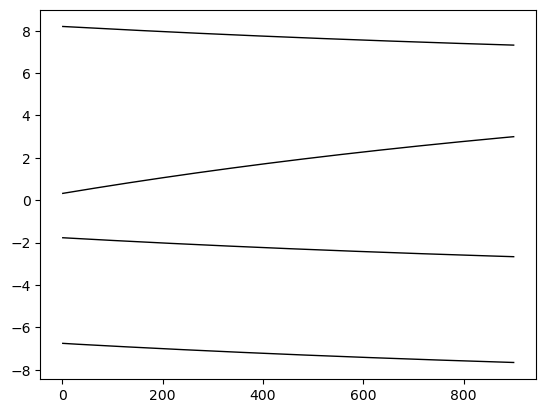

In [7]:
import matplotlib.pyplot as plt
import numpy as np



Temps = Temps_ori[:, :, :, 100:1000]

time = np.arange(1, len(np.squeeze(Temps[0, 0, 1, :])) + 1)

plt.figure()
idx=9
# Last loop (i == 10), plot in black
plt.plot(time, Temps[idx, 0, 1, :], 'k', linewidth=1)
plt.plot(time, Temps[idx, 0, 2, :], 'k', linewidth=1)
plt.plot(time, Temps[idx, 0, 3, :], 'k', linewidth=1)
plt.plot(time, Temps[idx, 0, 4, :], 'k', linewidth=1)

(<Figure size 640x480 with 4 Axes>,
 array([<Axes: ylabel='Box 1'>, <Axes: ylabel='Box 2'>,
        <Axes: ylabel='Box 3'>, <Axes: ylabel='Box 4'>], dtype=object))

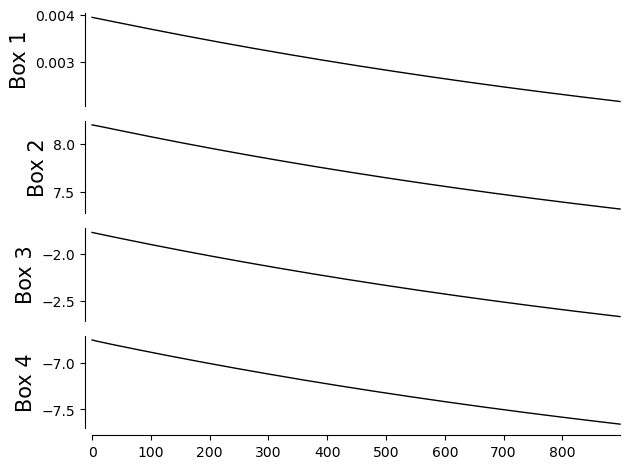

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import tigramite
from tigramite import data_processing as pp
from tigramite import plotting as tp
from tigramite.pcmci import PCMCI
from tigramite.independence_tests import parcorr, gpdc, cmiknn
import pandas as pd

idx = 9  # Index of the last simulation without noise
# Convert the dictionary to an array suitable for Tigramite's DataFrame
data_array = Temps[idx, 0, 1:5, :].T.copy()

# For data_array, for the first column, replace it with its derivative
first_col_diff = np.diff(data_array[:, 0])
# drop the last row of data_array
data_array = data_array[:-1, :]
# replace the first column with the derivative
data_array[:, 0] = first_col_diff


# Create a Tigramite DataFrame object
var_names = [f"Box {k+1}" for k in range(4)]

# create adataframe called 'df4stationary_check' with the data_array and the variable names
df4stationary_check= pd.DataFrame(data_array, columns=var_names)

dataframe_TEMP = pp.DataFrame(data_array, datatime=np.arange(data_array.shape[0]), var_names=var_names)
tp.plot_timeseries(dataframe_TEMP,label_fontsize=15,tick_label_size=10)


##
## Step 1: PC1 algorithm for selecting lagged conditions
##

Parameters:
independence test = par_corr
tau_min = 1
tau_max = 2
pc_alpha = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
max_conds_dim = None
max_combinations = 1



## Resulting lagged parent (super)sets:

    Variable Box 1 has 4 link(s):
    [pc_alpha = 0.2]
        (Box 1 -1): max_pval = 0.00000, |min_val| =  0.502
        (Box 1 -2): max_pval = 0.00000, |min_val| =  0.483
        (Box 4 -2): max_pval = 0.08014, |min_val| =  0.059
        (Box 4 -1): max_pval = 0.10257, |min_val| =  0.055

    Variable Box 2 has 5 link(s):
    [pc_alpha = 0.3]
        (Box 2 -1): max_pval = 0.00000, |min_val| =  0.742
        (Box 1 -2): max_pval = 0.00000, |min_val| =  0.324
        (Box 1 -1): max_pval = 0.00000, |min_val| =  0.315
        (Box 4 -2): max_pval = 0.06458, |min_val| =  0.062
        (Box 3 -2): max_pval = 0.21595, |min_val| =  0.042

    Variable Box 3 has 8 link(s):
    [pc_alpha = 0.05]
        (Box 3 -1): max_pval = 0.00000, |m

(<Figure size 2000x2000 with 1 Axes>, <Axes: >)

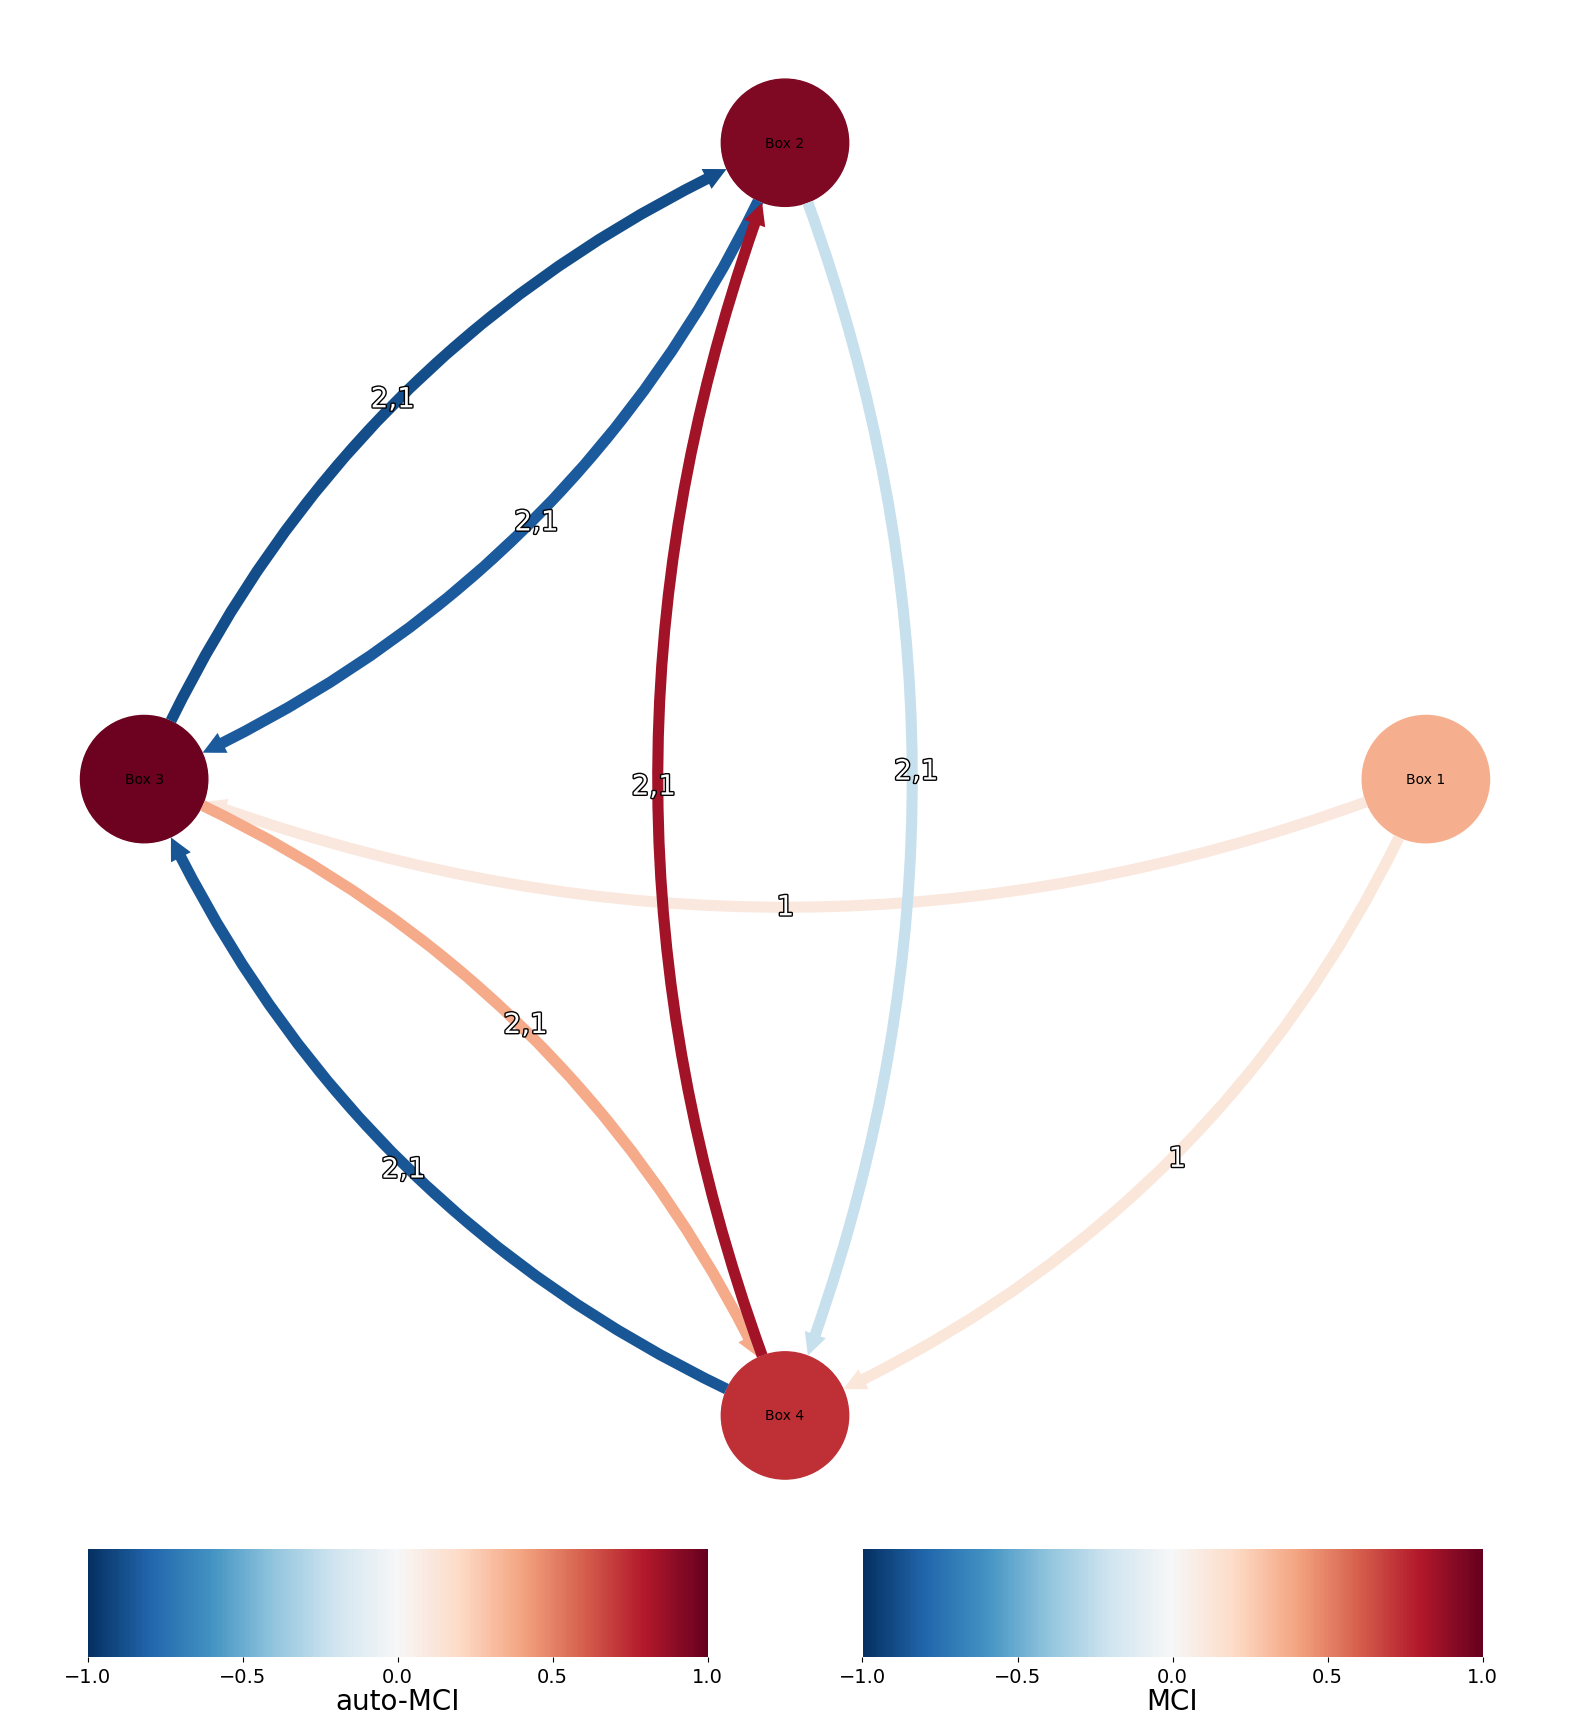

In [9]:
ParCorr = parcorr.ParCorr(significance='analytic')
pcmci = PCMCI(
    dataframe=dataframe_TEMP,
    cond_ind_test=ParCorr,
    verbosity=1)

pcmci.verbosity = 1
tau_max=2
results = pcmci.run_pcmci(tau_min=1, tau_max=tau_max, pc_alpha=None)
# q_matrix = pcmci.get_corrected_pvalues(p_matrix=results['p_matrix'], tau_max=tau_max, fdr_method='fdr_bh')

# create a figure
fig, ax = plt.subplots(1, 1, figsize=(20, 20), dpi=100)
tp.plot_graph(
    fig_ax=(fig, ax),
    graph = results['graph'],
    val_matrix=results['val_matrix'],
    var_names=var_names,
    link_colorbar_label='MCI',
    node_colorbar_label='auto-MCI',
    link_label_fontsize=20,
    label_fontsize=20,
    tick_label_size=14,
    node_label_size=10,
    edge_ticks=0.5,
    node_ticks=0.5,
    node_size=0.2
    )

# The model. Ref: Thomas Bauska

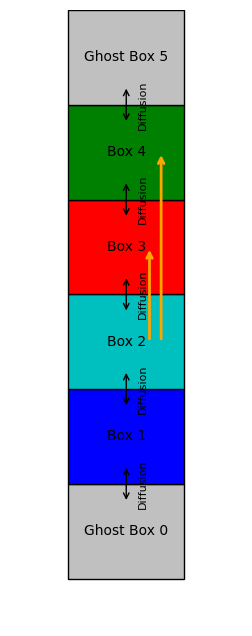

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Create a figure and axis
fig, ax = plt.subplots(figsize=(3, 8), dpi=100)

# Number of boxes including ghost boxes
num_boxes = 6  # Boxes from y=0 to y=5

color_list=['silver','b','c','r','g','silver']

# Draw rectangles for each grid cell
for y in range(num_boxes):
    if y == 0 or y == 5:
        # Ghost boxes (Neumann boundary conditions)
        rect = patches.Rectangle((0, y), 1, 1, linewidth=1, edgecolor='black', facecolor= color_list[y])
        ax.add_patch(rect)
        ax.text(0.5, y + 0.5, f'Ghost Box {y}', ha='center', va='center', fontsize=10)
    else:
        # Physical boxes
        rect = patches.Rectangle((0, y), 1, 1, linewidth=1, edgecolor='black', facecolor= color_list[y])
        ax.add_patch(rect)
        ax.text(0.5, y + 0.5, f'Box {y}', ha='center', va='center', fontsize=10)

# Draw diffusion arrows between adjacent boxes
for y in range(num_boxes - 1):
    # Draw bidirectional arrows (diffusion)
    ax.annotate(
        '', xy=(0.5, y + 0.8), xytext=(0.5, y + 1.2),
        arrowprops=dict(arrowstyle='<->', color='black', lw=1)
    )
    ax.text(0.6, y + 1, 'Diffusion', va='center', fontsize=8, rotation=90)


# Highlight the boxes involved in advection
advection_boxes = [2, 3, 4]  # Corresponding to y=2, y=3, y=4 in the code

# Draw advection arrows
# Advection removes from Box 2
# ax.annotate(
#     '', xy=(0.5, 2 + 0.1), xytext=(0.5, 2),
#     arrowprops=dict(arrowstyle='-|>', color='red', lw=2)
# )
# ax.text(0.6, 2 + 0.05, 'Advection Loss', va='center', fontsize=8, color='red')

# Advection adds to Box 3
# ax.annotate(
#     '', xy=(0.3, 3), xytext=(0.3, 2 + 0.9),
#     arrowprops=dict(arrowstyle='->', color='red', lw=2)
# )
# Advection adds to Box 4
ax.annotate(
    '', xy=(0.7, 3.5), xytext=(0.7, 2.5),
    arrowprops=dict(arrowstyle='->', color='orange', lw=2)
)

ax.annotate(
    '', xy=(0.8, 4.5), xytext=(0.8, 2.5),
    arrowprops=dict(arrowstyle='->', color='orange', lw=2)
)

ax.text(0.9, 3.5, 'Advection', va='center', fontsize=8, color='red', rotation=90)

# Set plot limits and remove axes
ax.set_xlim(-0.5, 1.5)
ax.set_ylim(-0.5, num_boxes)
ax.axis('off')

# Add title
# plt.title('Schematic of 1D Diffusion/Advection Model', fontsize=12)

# Display the plot
plt.show()


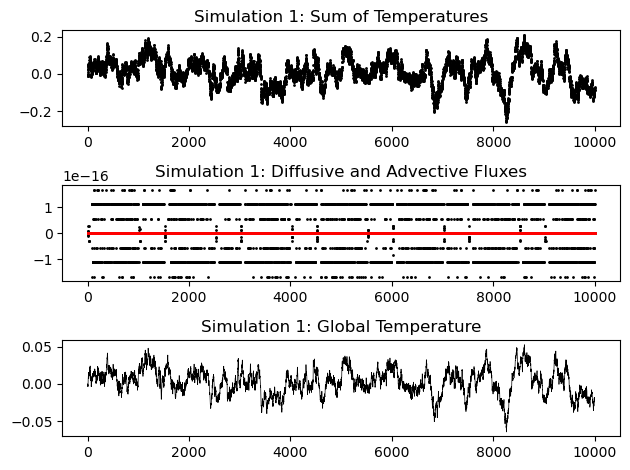

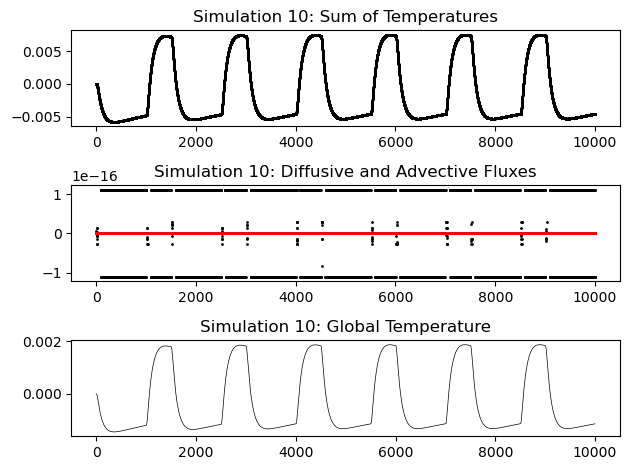

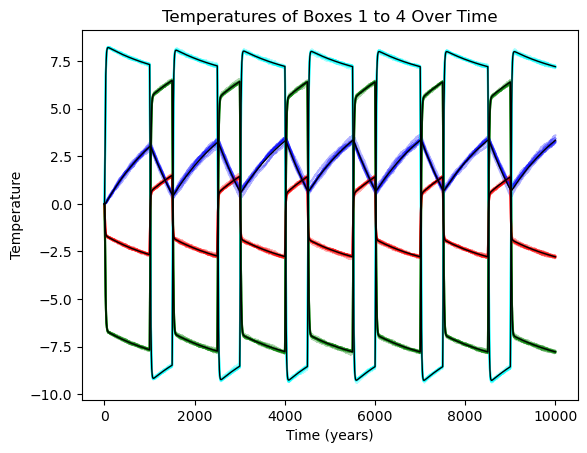

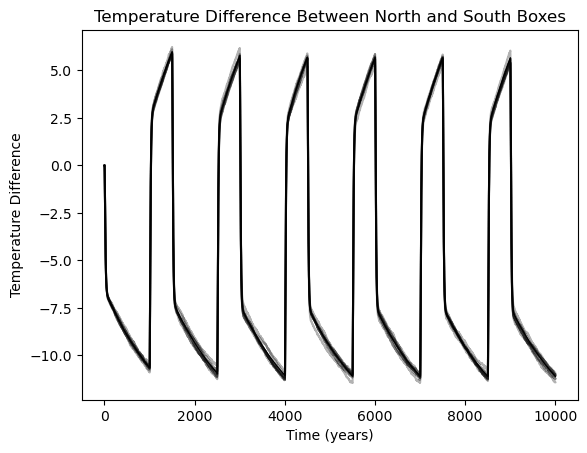

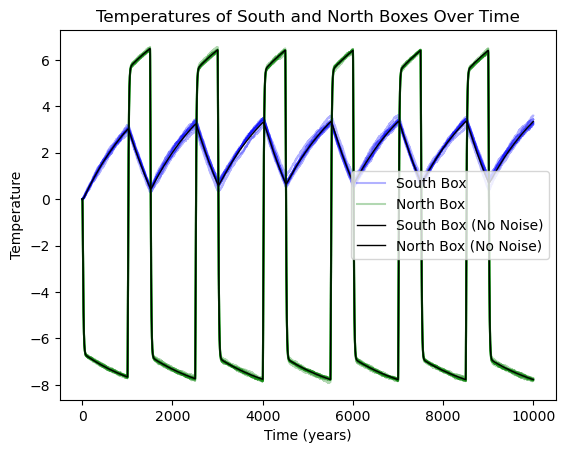

In [1]:
# ----------------------------------------------------------------------- #
#   Very rough draft of 1D diffusion/advection model for testing          #
#   Date: 14/10/2024            
#   Adapted from 2D diffusion/advection to there are some vestigial
#   features
#   Author: Thomas Bauska <thausk@bas.ac.uk>                              #
#                                                                         #
#=========================Basic Setup=====================================#
#-------------------------------------------------------------------------#

import numpy as np
import matplotlib.pyplot as plt

nx = 1     # core boxes akin to longitude (don't change!)
ny = 4     # core boxes akin to latitude (don't change!)

#--> NOTE: the boundary condition on the north and south (y) is a Neumann
# so there are a total of 6 boxes with boxes 1 and 6 forced to equal to boxes 
# 2 and 5, respectively. They are like ghost boxes such that derivative at the
# true boundary is zero.

# Boundary conditions on east and west (x) are wrapped around such that the grid is continuous

lengthx = 1  # domain length along x (unitless) (don't change!)
lengthy = 4  # domain length along y (unitless) don't change!)

dt = 1       # time step [nominally yr]  (there are some stability check below)
runlength = 10000  # length in years  <======CAN CHANGE 
nsteps = int(runlength / dt)  # number of timesteps (feel free to change)
bpss_reoccurence = 1000  # recurrence interval in years <======CAN CHANGE 
bpss_length = 500        # length of perturbation in years <======CAN CHANGE 

num_simulations = 10  # Total number of simulations

# Initialize arrays to save Temp, F, and Fadv for all loops
Temps = np.zeros((num_simulations, nx, ny + 2, nsteps))
Fs = np.zeros((num_simulations, nx, ny + 2, nsteps))
Fadvs = np.zeros((num_simulations, nx, ny + 2, nsteps))
global_temp_arrs = np.zeros((num_simulations, nsteps))
area_temp_arrs = np.zeros((num_simulations, nsteps))

for i in range(1, num_simulations + 1):  # this is a little loop which runs 9 simulations with noise and the last one without.

    # ===============Switches, Knobs and Tunable Parameters=====================#
    # -------------------------------------------------------------------------#
    # --Diffusion--#
    Dy_var = [0.0005, 0.0005, 0.1, 0.1, 0.1]  # Variable diffusive parameter along y  <======CAN CHANGE 
    # wy = 5  # advective flux (currently defunct)
    maxD = 0.1  # some relict code to check numerical stability. Here you can enter maximum diffusion rate
    maxw = 0.0  # some relict code to check numerical stability. Here you can enter maximum advection rate

    # --Noise--#
    if i == 10:
        wnoise_level = 0
    else:
        wnoise_level = 0.005  # total white noise level <======CAN CHANGE 
        # wnoise_level = 0.00005

    wnoise_sigma = np.array([1, 1, 1, 1, 1, 1]) * wnoise_level  # sets level of white noise in each latitude 
    wnoise_dt = 1  # sets timestep for noise (ie. if dt = 1 an annual noise timeseries is interpolated to the model grid)

    # --Response times--#
    arb_bpss_target = 0   # this sets the magnitude of the bipolar seesaw heat flux.
    arb_bpss_tau = 10     # this sets the rate (nominally years) that the model moves towards the full bipolar seesaw heat flux.

    rectifier_global_temp = 0      # this forces the global average temperature to tend to the set value
    rectifier_global_tau = 100     # this sets the rate (nominally years) that the model tends back to the set values. If you want to turn off the effect, set it to a very large number.

    rectifier_area_temp = 0        # this forces a set of grid cells in the model to to the set value.  
    rectifier_area_tau = 100000    # this sets the rate (nominally years) that the model tends back to the set values. If you want to turn off the effect, set it to a very large number.

    gain = [0, 0, 0, 0, 0, 0]      # this currently doesn't work..

    timetrip_pre = np.arange(1, 21)

    timetrip = np.column_stack((
        bpss_reoccurence * timetrip_pre + bpss_length * (timetrip_pre - 1),
        (bpss_reoccurence + bpss_length) * timetrip_pre
    ))

    # ============Pre-processing of user-defined data==========================#
    # -------------------------------------------------------------------------#
    # Calculate grid steps
    hx = lengthx / nx      # grid step along x (unitless) 
    hy = lengthy / ny      # grid step along y (unitless) 

    # Numerical setup: time step (stability conditions)
    sigma = 0.7                       # safety coefficient
    dt_diff = (1 / 4) * min(hx ** 2, hy ** 2) / maxD   # diffusion [yr]
    if maxw == 0:
        dt_conv = np.inf
    else:
        dt_conv = 4 * maxD / (maxw ** 2)  # convection [yr]
    dtstabilitycheck = sigma * min(dt_diff, dt_conv)   # time step [yr]

    if dt > dtstabilitycheck:
        print('might be numerically unstable')
        print(dt / dtstabilitycheck)
    else:
        pass

    # Calculate time steps
    time = np.arange(1, nsteps + 1) * dt

    # Memory allocation
    Temp = np.zeros((nx, ny + 2, nsteps))     # Temperature
    arb_bpss_target_time = np.zeros(nsteps)   # the target value for the bipolar seesaw heat flux parameter. The actual value tends to this in a lagged response.
    arb_bpss_actual_time = np.zeros(nsteps)   # the actual value for the bipolar seesaw heat flux parameter.
    Fadv = np.zeros((nx, ny + 2, nsteps))     # Advective Flux 
    F = np.zeros((nx, ny + 2, nsteps))        # Diffusive Flux
    Fgain = np.zeros((nx, ny + 2, nsteps))    # Gain Flux (not active!)
    Frectifier_global = np.zeros((nx, ny + 2, nsteps))  # Rectifier Flux when using the global mean temperature
    Frectifier_area = np.zeros((nx, ny + 2, nsteps))      # Rectifier Flux when using the just a set area
    wnoiseint = np.zeros((nx, ny + 2, nsteps))           # white noise

    # White noise production
    wnoiserawtime = np.arange(0, time[-1] + wnoise_dt, wnoise_dt)
    wnoiseraw_shape = (nx, ny + 2, len(wnoiserawtime))
    wnoiseraw = wnoise_sigma.reshape(1, -1, 1) * np.random.randn(*wnoiseraw_shape)

    # Interpolate white noise to time grid
    for y in range(ny + 2):
        for x in range(nx):
            wnoiseint[x, y, :] = np.interp(time, wnoiserawtime, wnoiseraw[x, y, :])

    # Initialize arrays for global and area temperature
    global_temp_arr = np.zeros(nsteps)
    area_temp_arr = np.zeros(nsteps)

    # ============================Core Equations===============================#
    # -------------------------------------------------------------------------#
    for t in range(nsteps - 1):
        for y in range(1, 5):
            x = 0
            F[x, y, t + 1] = +(Dy_var[y] * dt / hy ** 2) * (Temp[x, y + 1, t] - Temp[x, y, t]) \
                            + (Dy_var[y - 1] * dt / hy ** 2) * (Temp[x, y - 1, t] - Temp[x, y, t])
        #
        # -----Special Advection Forcing------#
        x = 0
        y = 4
        arb_bpss_target_time[t] = arb_bpss_target
        arb_bpss_actual_time[t + 1] = arb_bpss_actual_time[t] \
                                      + (arb_bpss_target_time[t] - arb_bpss_actual_time[t]) * dt * (1 / arb_bpss_tau)

        Fadv[x, y - 2, t + 1] = -arb_bpss_actual_time[t] * dt
        Fadv[x, y - 1, t + 1] = +0.5 * arb_bpss_actual_time[t] * dt
        Fadv[x, y, t + 1] = +0.5 * arb_bpss_actual_time[t] * dt

        # -----Summing up, Switches and Feedbacks-----#        
        global_temp_arr[t] = Temp[0, 1:5, t].mean()
        area_temp_arr[t] = Temp[0, 2:4, t].mean()
        Frectifier_global[:, :, t + 1] = (rectifier_global_temp - global_temp_arr[t]) * (1 / rectifier_global_tau) * dt

        Frectifier_area[x, 2:4, t + 1] = (rectifier_area_temp - area_temp_arr[t]) * (1 / rectifier_area_tau) * dt
        Temp[:, :, t + 1] = Temp[:, :, t] \
                           + F[:, :, t + 1] \
                           + Fadv[:, :, t + 1] \
                           + wnoiseint[:, :, t + 1] \
                           + Frectifier_global[:, :, t + 1] \
                           + Frectifier_area[:, :, t + 1] \
                           + Fgain[:, :, t]
        Fgain[:, :, t + 1] = np.array(gain).reshape(1, -1) * (Temp[:, :, t + 1] - Temp[:, :, t])

        # ----Finding the right time to turn off and on----#   
        if any((time[t] > timetrip[k, 0]) and (time[t] < timetrip[k, 1]) for k in range(20)):
            arb_bpss_target = 1   # this in ON trip <======CAN CHANGE 
        else:
            arb_bpss_target = -1  # this in OFF trip <======CAN CHANGE 

        # North and South Boundary conditions (Neumann's)
        Temp[0, 0, t + 1] = Temp[0, 1, t + 1]
        Temp[0, 5, t + 1] = Temp[0, 4, t + 1]

    # Save Temp, F, Fadv, global_temp_arr, area_temp_arr for each loop
    idx = i - 1  # Adjust index since Python is 0-based
    Temps[idx] = Temp
    Fs[idx] = F
    Fadvs[idx] = Fadv
    global_temp_arrs[idx] = global_temp_arr
    area_temp_arrs[idx] = area_temp_arr

    # =============================Figures=====================================#
    # -------------------------------------------------------------------------#
    # For Figure 1, plot only for i == 1 or i == 10
    if i == 1 or i == 10:
        plt.figure(1)
        plt.subplot(3, 1, 1)
        plt.plot(time, np.squeeze(np.sum(Temp[:, 1:5, :], axis=(0, 1))), 'ko', markersize=1)
        plt.title(f'Simulation {i}: Sum of Temperatures')
        plt.subplot(3, 1, 2)
        plt.plot(time, np.squeeze(np.sum(F[:, 1:5, :], axis=(0, 1))), 'ko', markersize=1)
        plt.plot(time, np.squeeze(np.sum(Fadv[:, 1:5, :], axis=(0, 1))), 'ro', markersize=1)
        plt.title(f'Simulation {i}: Diffusive and Advective Fluxes')
        plt.subplot(3, 1, 3)
        plt.plot(time[:-1], global_temp_arr[:-1], 'k', linewidth=0.5)
        plt.title(f'Simulation {i}: Global Temperature')
        plt.tight_layout()
        plt.show()

# After the loop, stack results and plot Figures 2, 3, and 6

# Figure 2: Temperatures of Boxes 1 to 4 over time
plt.figure(2)
for idx in range(num_simulations):
    if idx == num_simulations - 1:
        # Last loop (i == 10), plot in black
        plt.plot(time, Temps[idx, 0, 1, :], 'k', linewidth=1)
        plt.plot(time, Temps[idx, 0, 2, :], 'k', linewidth=1)
        plt.plot(time, Temps[idx, 0, 3, :], 'k', linewidth=1)
        plt.plot(time, Temps[idx, 0, 4, :], 'k', linewidth=1)
    else:
        # Other loops, plot in colors with transparency
        plt.plot(time, Temps[idx, 0, 1, :], color='blue', alpha=0.3)
        plt.plot(time, Temps[idx, 0, 2, :], color='cyan', alpha=0.3)
        plt.plot(time, Temps[idx, 0, 3, :], color='red', alpha=0.3)
        plt.plot(time, Temps[idx, 0, 4, :], color='green', alpha=0.3)
plt.title('Temperatures of Boxes 1 to 4 Over Time')
plt.xlabel('Time (years)')
plt.ylabel('Temperature')
plt.show()

# Figure 3: Difference between North and South Box Temperatures
plt.figure(3)
for idx in range(num_simulations):
    temp_diff = Temps[idx, 0, 4, :] - Temps[idx, 0, 1, :]
    if idx == num_simulations - 1:
        plt.plot(time, temp_diff, 'k', linewidth=1)
    else:
        plt.plot(time, temp_diff, 'k', alpha=0.3)
plt.title('Temperature Difference Between North and South Boxes')
plt.xlabel('Time (years)')
plt.ylabel('Temperature Difference')
plt.show()

# Figure 6: Temperatures of South and North Boxes over time
plt.figure(6)
for idx in range(num_simulations):
    if idx == num_simulations - 1:
        plt.plot(time, Temps[idx, 0, 1, :], 'k', linewidth=1, label='South Box (No Noise)')
        plt.plot(time, Temps[idx, 0, 4, :], 'k', linewidth=1, label='North Box (No Noise)')
    else:
        plt.plot(time, Temps[idx, 0, 1, :], 'b', alpha=0.3, label='South Box' if idx == 0 else "")
        plt.plot(time, Temps[idx, 0, 4, :], 'g', alpha=0.3, label='North Box' if idx == 0 else "")
plt.title('Temperatures of South and North Boxes Over Time')
plt.xlabel('Time (years)')
plt.ylabel('Temperature')
plt.legend()
plt.show()


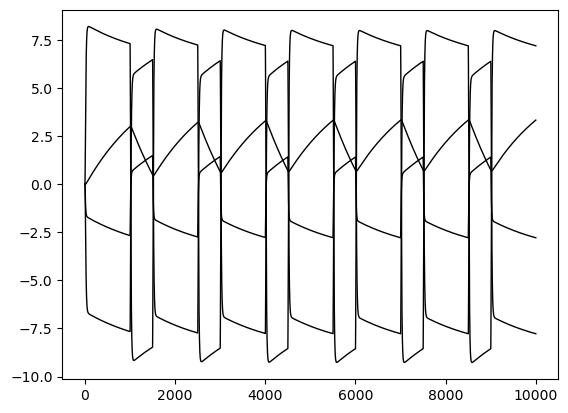

In [2]:
plt.figure()
idx=9
# Last loop (i == 10), plot in black
plt.plot(time, Temps[idx, 0, 1, :], 'k', linewidth=1)
plt.plot(time, Temps[idx, 0, 2, :], 'k', linewidth=1)
plt.plot(time, Temps[idx, 0, 3, :], 'k', linewidth=1)
plt.plot(time, Temps[idx, 0, 4, :], 'k', linewidth=1)

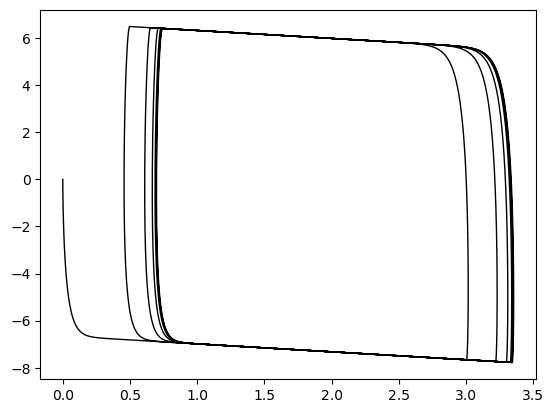

In [7]:
plt.figure()
idx=9

plt.plot(Temps[idx, 0, 1, :], Temps[idx, 0, 4, :], 'k', linewidth=1)


In [3]:
Temps[idx, 0, 1:5, :].shape

(4, 10000)

In [24]:
data_array.shape

(10000, 4)